# モデルの選定と保存を行うノートブック
## V4_2
### ディレクトリに注意！！

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt

import seaborn
from pandas import DataFrame
from tqdm import tqdm
from imblearn.under_sampling import RandomUnderSampler #アンダーサンプリング用
from sklearn.model_selection import train_test_split
import pickle
# 機械学習用
from sklearn.cluster import KMeans #クラスタリング用
from sklearn.ensemble import RandomForestClassifier#ランダムフォレスト
from copy import deepcopy as cp
from sklearn.linear_model import LogisticRegression
import time
import datetime
from dateutil.relativedelta import relativedelta
import os #ディレクトリ作成用
import xgboost as xgb
import sys
from sklearn.preprocessing import StandardScaler#モデルの評価用に標準化する関数
import scipy.stats#モデルの評価用に標準化する関数
import warnings

#自作のモジュールのインポート
#sys.path.append("..")
import module.master as master
import module.modeling_scores as modeling


In [2]:
def get_season_date(now_date):#日付(datetime型)を渡すと，その日付で購買予測を行う際に使用するデータの区間を返す関数
    use_data_year=now_date.year
    if (now_date.month>=1)and(now_date.month<4):
        use_data_month=1
    elif (now_date.month>=4)and(now_date.month<7):
        use_data_month=4
    elif (now_date.month>=7)and(now_date.month<10):
        use_data_month=7
    elif (now_date.month>=10):
        use_data_month=10
    else:
        print('what???????')
    use_data_date=datetime.datetime(year=use_data_year, month=use_data_month,day=1)
    return use_data_date


def get_4_section_dt(now_date):#今いる区間から直近4区間の開始日をリストで返してくれる関数
    now_sec_date=get_season_date(now_date)
    diff_sec_stdates=[0]*4
    for i in range(len(diff_sec_stdates)):
        diff_sec_stdates[3-i]=now_sec_date- relativedelta(months=3*(i+1))#古い順に日付を入れていく
    return diff_sec_stdates

def add_std_score(good_model_df,feature_weights):#偏差値と相関係数をもとにしたスコアを与える
    add_score_df=pd.DataFrame()
    for com in sorted(good_model_df['target_com'].value_counts().index):
        target_com_df=good_model_df[good_model_df['target_com']==com]
        for f_name,weight in feature_weights.items():
            target_com_df.loc[:,'{}_score'.format(f_name)]=scipy.stats.zscore(target_com_df['{}'.format(f_name)].values)
            target_com_df.loc[:,'{}_score'.format(f_name)]=target_com_df['{}_score'.format(f_name)]*weight
        target_com_df=target_com_df.fillna(0)
        target_com_df['score']=0
        for f_name in feature_weights.index:
            target_com_df['score']=target_com_df['score']+target_com_df['{}_score'.format(f_name)]
        #display(target_com_df)
        add_score_df=pd.concat([add_score_df, target_com_df], axis=0)#きめのパラメータで切り落としたので結合
    
    return add_score_df


def select_use_model(model_std_score_df):#相関係数と標準偏差によって与えられたscoreをもとに最終的に使用するモデルを選定する関数
    use_model_df=pd.DataFrame()
    for com in sorted(model_std_score_df['target_com'].value_counts().index):
        target_com_df=model_std_score_df[model_std_score_df['target_com']==com].copy()
        com_selected_row=target_com_df.sort_values('score', ascending=False).iloc[:1]
        #use_model_df=pd.concat([use_model_df, com_selected_row], axis=0)#きめのパラメータで切り落としたので結合
        use_model_df=use_model_df.append(com_selected_row,ignore_index=True)
    return use_model_df


def twin_plt(x,y1,y2,x_n,y1_n,y2_n):#2本軸でのグラフの描写
    fig = plt.figure(figsize=(19,8))
    plt.tick_params(colors='black')
    plt.rcParams["font.size"] = 18
    
    ax1 = fig.add_subplot()
    fig.set_facecolor(color='white')
    ax1.plot(x, y1,label=y1_n)
    ax1.tick_params()
    plt.ylim(80, 200)
    ax2 = ax1.twinx()
    #print(y2)
    ax2.plot(x, y2,label=y2_n,color='red')
    ax1.axhline(100,ls = "-.",color='green')
    #ax2.tick_params(colors='white')
    ax2.tick_params()

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc='lower center')

    #ax1.set_xlabel(x_n,color='white')
    #ax1.set_ylabel(y1_n,color='white')
    #ax2.set_ylabel(y2_n,color='white')
    ax1.set_xlabel(x_n)
    ax1.set_ylabel(y1_n)
    ax2.set_ylabel(y2_n)
    plt.show()
    return None

In [3]:
version='V4_2'#バージョン
#use_modelの書き込み先作成のための箱作り
place_master=master.get_place_master()
for place in place_master.items():
    #print(place[0],place[1],'\n')
    place_name=place[1]
    dir_path = "../bot_database/{place_name}/model_score_{place_name}/use_model/{version}".format(place_name=place_name,version=version)#作成したデータの書き込み先#使用するデータの読み込み
    if os.path.exists(dir_path)==False:
        os.makedirs(dir_path)
    else:
        pass

## 使用するモデルの選定と，選定したモデルのパラメータシートを出力
相関係数と偏差値によって使用するモデルの出力を行う

In [4]:
#warnings.simplefilter('ignore')
#相関係数と全体分析の結果をもとに最終的に使用するモデルを選定する
place_master=master.get_place_master()
place_names=[place_name for place_name in place_master.values()]#会場名のみを収納した配列
#絶対に固定のパラメータたち
plus_m_th=2
#plus_m_th=3
num_hit_th=5
version='V4_2'
mode='model_score_'
mode_type='recent'
#today=datetime.date.today()#今日の日付の取得
today=datetime.datetime(year=2021, month=10,day=1)
now_date=today




#コード本文

#for place_name in place_names[:10]:
for place_name in place_names:
    #place_name='kiryu'

    diff_sec_dates=get_4_section_dt(now_date)#直近４区間の開始日をリストで取得
    now_date_txt=now_date.strftime('%Y%m%d')
    diff_sec_dates=diff_sec_dates[1:]#テスト時のみの特別処理！！データが１区間だけ足りないので今回はスルーする
    #閾値にあてはまった　モデルたちがどんな奴らなのかを確認する
    for i in range(len(diff_sec_dates)):
        sec_date=diff_sec_dates[i]
        sec_date_txt=sec_date.strftime('%Y%m%d')
        #csv_path='../../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{version}_{mode_type}_TRhit_pM{plus_month}_st{now_ym}_total_analysis.csv'.format(place_name=place_name,mode_type=mode_type,version=version,plus_month=plus_m_th,num_hit=num_hit_th,now_ym=now_date_txt)
        csv_path='../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{version}_{mode_type}_TRhit_pM{plus_month}_st{now_ym}_total_analysis.csv'.format(place_name=place_name,mode_type=mode_type,version=version,plus_month=plus_m_th,num_hit=num_hit_th,now_ym=sec_date_txt)
        totol_analysis_df=pd.read_csv(csv_path, encoding='utf_8_sig')
        totol_analysis_df=totol_analysis_df.drop(["Unnamed: 0"],axis=1)
        print('place_name:',place_name,'========================================================================================')
        #閾値の取得
        th_s=totol_analysis_df[totol_analysis_df['num_plus_com_mean']>2].sort_values('minus_model_per_mean').iloc[0]#plusだったcom数の平均が２より大きい
        #th_s=totol_analysis_df[totol_analysis_df['num_plus_com_mean']>3].sort_values('minus_model_per_mean').iloc[0]#plusだったcom数の平均が２より大きい
        #display(th_s)
        select_model_df=pd.DataFrame()
        print('now_date:',sec_date_txt)
        dir_path='../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{place_name}_{mode}st{now_ym}_finalM3_{version}.csv'.format(place_name=place_name,mode=mode,now_ym=sec_date_txt,version=version)
        model_score_df=pd.read_csv(dir_path, encoding='utf_8_sig')
        model_score_df=model_score_df.drop(["Unnamed: 0"],axis=1)
        #選定したパラメータで切り落とし
        selected_m=model_score_df[model_score_df['gain_test']>=th_s["gain_th"]].copy()
        selected_m=selected_m[selected_m['gain_std_test']<=th_s["gain_std_th"]].copy()
        selected_m=selected_m[selected_m['buy_hit_per_test']>=th_s["hit_per_th"]].copy()
        selected_m=selected_m[selected_m['buy_hit_per_std_test']<=th_s["hit_std_th"]].copy()
        selected_m=selected_m[selected_m['num_hit_test']>=th_s["num_hit_th"]].copy()#的中した予測の数で切り捨てる,これも可変していく方針に変更した
        select_model_df=pd.concat([select_model_df, selected_m], axis=0)#きめのパラメータで切り落としたので結合
        #偏差値評価を用いた実際に使用するモデルの切り抜き(方針：使用する区間の１つ前の区間(test5,final3の区間))をもとに相関係数を算出
        date_cal_std=sec_date- relativedelta(months=3)#一つ前の区間の日付を切り抜く(1区間前のfinalありから収益との相関係数を算出したい)
        date_cal_std_txt=date_cal_std.strftime('%Y%m%d')
        dir_path='../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{place_name}_{mode}st{now_ym}_finalM3_{version}.csv'.format(place_name=place_name,mode=mode,now_ym=date_cal_std_txt,version=version)
        model_score_df=pd.read_csv(dir_path, encoding='utf_8_sig')
        model_score_df=model_score_df.drop(["Unnamed: 0"],axis=1)
        #決めのパラメータでいったん切り落とし
        model_score_df=model_score_df[model_score_df['plus_month_num_test']>=plus_m_th].copy()#収益がプラスだった月の数で切り捨てる
        model_score_df=model_score_df[model_score_df['num_hit_test']>=num_hit_th].copy()#的中した予測の数で切り捨てる，大体一カ月に一件くらいをイメージ
        version_corr_df=model_score_df.corr()
        feature_weights=version_corr_df.loc['gain_final']['total_get_test':'diff_mea_med_test']#相関係数を代用した変数ごとの重みづけ
        print(feature_weights)
        #display(feature_weights)
        model_std_score_df=add_std_score(select_model_df,feature_weights)
    #     if place_name=='toda':
    #         model_std_score_df.to_csv('csv/toda_{dt}.csv'.format(dt=now_ym))
        use_models=select_use_model(model_std_score_df)#相関係数と標準偏差によって与えられたscoreをもとに最終的に使用するモデルを選定する関数
        dir_path = "../bot_database/{place_name}/model_score_{place_name}/use_model/{version}/use_model_{place_name}_{now_ym}_{version}.csv".format(place_name=place_name,version=version,now_ym=sec_date_txt)#作成したデータの書き込み先#使用するデータの読み込み
        use_models.to_csv(dir_path)

place_name: kiryu ========================================================================================
now_date: 20210101
total_get_test          0.368025
total_use_test         -0.124537
num_com_test           -0.624872
num_pred_test          -0.124537
gain_test               0.418493
gain_std_test           0.447960
num_hit_test           -0.385362
buy_hit_per_test       -0.294876
buy_hit_per_std_test    0.055077
plus_month_num_test    -0.120445
diff_mea_med_test       0.051350
Name: gain_final, dtype: float64


c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: kiryu ========================================================================================
now_date: 20210401
total_get_test          0.153949
total_use_test         -0.363694
num_com_test           -0.021747
num_pred_test          -0.363694
gain_test               0.503407
gain_std_test           0.464584
num_hit_test           -0.144873
buy_hit_per_test       -0.025786
buy_hit_per_std_test    0.003219
plus_month_num_test    -0.182858
diff_mea_med_test       0.264444
Name: gain_final, dtype: float64


c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: kiryu ========================================================================================
now_date: 20210701
total_get_test         -0.195130
total_use_test          0.027114
num_com_test            0.448949
num_pred_test           0.027114
gain_test              -0.412567
gain_std_test          -0.371571
num_hit_test            0.337574
buy_hit_per_test        0.337299
buy_hit_per_std_test    0.384189
plus_month_num_test    -0.245835
diff_mea_med_test       0.191895
Name: gain_final, dtype: float64


c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: toda ========================================================================================
now_date: 20210101
total_get_test          0.401807
total_use_test         -0.050850
num_com_test            0.367733
num_pred_test          -0.050850
gain_test               0.574735
gain_std_test           0.463093
num_hit_test            0.412548
buy_hit_per_test        0.393066
buy_hit_per_std_test    0.309202
plus_month_num_test     0.064271
diff_mea_med_test      -0.123069
Name: gain_final, dtype: float64
place_name: toda ========================================================================================
now_date: 20210401
total_get_test         -0.376314
total_use_test          0.121384
num_com_test            0.280868
num_pred_test           0.121384
gain_test              -0.428026
gain_std_test          -0.309880
num_hit_test            0.069681
buy_hit_per_test       -0.081961
buy_hit_per_std_test   -0.195525
plus_month_num_test     0.017164
diff_mea_med_test       

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: toda ========================================================================================
now_date: 20210701
total_get_test         -0.315237
total_use_test         -0.450057
num_com_test            0.298254
num_pred_test          -0.450057
gain_test               0.258514
gain_std_test          -0.008915
num_hit_test           -0.055974
buy_hit_per_test        0.498601
buy_hit_per_std_test    0.326807
plus_month_num_test     0.156514
diff_mea_med_test      -0.119331
Name: gain_final, dtype: float64


c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: edogawa ========================================================================================
now_date: 20210101
total_get_test         -0.500665
total_use_test         -0.412065
num_com_test            0.114903
num_pred_test          -0.412065
gain_test              -0.003466
gain_std_test          -0.117646
num_hit_test            0.013074
buy_hit_per_test        0.354493
buy_hit_per_std_test    0.231138
plus_month_num_test     0.148255
diff_mea_med_test      -0.047029
Name: gain_final, dtype: float64


c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: edogawa ========================================================================================
now_date: 20210401
total_get_test         -0.226808
total_use_test         -0.259598
num_com_test            0.247569
num_pred_test          -0.259598
gain_test               0.222123
gain_std_test          -0.024631
num_hit_test            0.060158
buy_hit_per_test        0.378519
buy_hit_per_std_test    0.520346
plus_month_num_test     0.061707
diff_mea_med_test      -0.191398
Name: gain_final, dtype: float64


c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: edogawa ========================================================================================
now_date: 20210701
total_get_test          0.099999
total_use_test         -0.006004
num_com_test            0.348029
num_pred_test          -0.006004
gain_test               0.057071
gain_std_test          -0.077649
num_hit_test            0.246227
buy_hit_per_test        0.305279
buy_hit_per_std_test   -0.033052
plus_month_num_test     0.229047
diff_mea_med_test       0.187434
Name: gain_final, dtype: float64


c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: heiwazima ========================================================================================
now_date: 20210101
total_get_test         -0.131295
total_use_test         -0.034600
num_com_test           -0.190108
num_pred_test          -0.034600
gain_test              -0.122373
gain_std_test          -0.089498
num_hit_test           -0.170536
buy_hit_per_test       -0.247495
buy_hit_per_std_test    0.039285
plus_month_num_test     0.110036
diff_mea_med_test      -0.328958
Name: gain_final, dtype: float64
place_name: heiwazima ========================================================================================
now_date: 20210401
total_get_test         -0.209273
total_use_test         -0.370031
num_com_test            0.516733
num_pred_test          -0.370031
gain_test               0.131160
gain_std_test           0.217011
num_hit_test            0.130796
buy_hit_per_test        0.614950
buy_hit_per_std_test    0.367502
plus_month_num_test     0.015557
diff_mea_med_t

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: heiwazima ========================================================================================
now_date: 20210701
total_get_test          0.051416
total_use_test          0.042217
num_com_test            0.039287
num_pred_test           0.042217
gain_test              -0.004404
gain_std_test          -0.052954
num_hit_test            0.118464
buy_hit_per_test        0.030022
buy_hit_per_std_test   -0.041265
plus_month_num_test    -0.078479
diff_mea_med_test      -0.016618
Name: gain_final, dtype: float64


c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: tamagawa ========================================================================================
now_date: 20210101
total_get_test         -0.110042
total_use_test         -0.155079
num_com_test            0.070552
num_pred_test          -0.155079
gain_test              -0.019023
gain_std_test          -0.245250
num_hit_test            0.021304
buy_hit_per_test        0.180267
buy_hit_per_std_test    0.134610
plus_month_num_test     0.141312
diff_mea_med_test       0.138363
Name: gain_final, dtype: float64


c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: tamagawa ========================================================================================
now_date: 20210401
total_get_test         -0.080711
total_use_test         -0.265951
num_com_test            0.001393
num_pred_test          -0.265951
gain_test               0.201697
gain_std_test           0.066801
num_hit_test           -0.083491
buy_hit_per_test        0.128642
buy_hit_per_std_test   -0.025672
plus_month_num_test     0.020486
diff_mea_med_test       0.036904
Name: gain_final, dtype: float64


c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: tamagawa ========================================================================================
now_date: 20210701
total_get_test         -0.058265
total_use_test          0.020025
num_com_test            0.098468
num_pred_test           0.020025
gain_test              -0.127480
gain_std_test          -0.188691
num_hit_test            0.077169
buy_hit_per_test        0.150587
buy_hit_per_std_test    0.243541
plus_month_num_test    -0.008922
diff_mea_med_test      -0.321474
Name: gain_final, dtype: float64


c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: hamanako ========================================================================================
now_date: 20210101
total_get_test          0.143638
total_use_test          0.043183
num_com_test           -0.077725
num_pred_test           0.043183
gain_test               0.108522
gain_std_test           0.142740
num_hit_test            0.027660
buy_hit_per_test        0.004478
buy_hit_per_std_test   -0.242829
plus_month_num_test    -0.253062
diff_mea_med_test       0.132120
Name: gain_final, dtype: float64


c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: hamanako ========================================================================================
now_date: 20210401
total_get_test         -0.305166
total_use_test         -0.084857
num_com_test            0.685581
num_pred_test          -0.084857
gain_test              -0.332891
gain_std_test          -0.383491
num_hit_test            0.415190
buy_hit_per_test        0.662753
buy_hit_per_std_test    0.172464
plus_month_num_test    -0.101860
diff_mea_med_test       0.026456
Name: gain_final, dtype: float64


c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: hamanako ========================================================================================
now_date: 20210701
total_get_test          0.083974
total_use_test         -0.027569
num_com_test            0.546538
num_pred_test          -0.027569
gain_test               0.143653
gain_std_test          -0.040098
num_hit_test            0.346836
buy_hit_per_test        0.573432
buy_hit_per_std_test    0.391028
plus_month_num_test     0.370040
diff_mea_med_test      -0.089856
Name: gain_final, dtype: float64


c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: gamagori ========================================================================================
now_date: 20210101
total_get_test         -0.191570
total_use_test         -0.091989
num_com_test            0.382495
num_pred_test          -0.091989
gain_test              -0.150283
gain_std_test          -0.154787
num_hit_test            0.053120
buy_hit_per_test        0.187409
buy_hit_per_std_test    0.098853
plus_month_num_test    -0.164583
diff_mea_med_test       0.084350
Name: gain_final, dtype: float64
place_name: gamagori ========================================================================================
now_date: 20210401
total_get_test         -0.651160
total_use_test         -0.506976
num_com_test            0.227087
num_pred_test          -0.506976
gain_test              -0.446046
gain_std_test          -0.352845
num_hit_test           -0.074283
buy_hit_per_test        0.330867
buy_hit_per_std_test    0.446836
plus_month_num_test     0.078624
diff_mea_med_tes

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: gamagori ========================================================================================
now_date: 20210701
total_get_test          0.044522
total_use_test          0.001415
num_com_test            0.173714
num_pred_test           0.001415
gain_test               0.236870
gain_std_test          -0.021096
num_hit_test            0.225515
buy_hit_per_test        0.208715
buy_hit_per_std_test   -0.013632
plus_month_num_test     0.159401
diff_mea_med_test      -0.117177
Name: gain_final, dtype: float64


c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


place_name: tokoname ========================================================================================
now_date: 20210101
total_get_test         -0.119173
total_use_test         -0.129874
num_com_test           -0.220686
num_pred_test          -0.129874
gain_test              -0.014739
gain_std_test           0.009578
num_hit_test           -0.141709
buy_hit_per_test       -0.101000
buy_hit_per_std_test   -0.031072
plus_month_num_test    -0.043227
diff_mea_med_test      -0.063667
Name: gain_final, dtype: float64


c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: tokoname ========================================================================================
now_date: 20210401
total_get_test         -0.031559
total_use_test         -0.097780
num_com_test           -0.310505
num_pred_test          -0.097780
gain_test               0.108359
gain_std_test           0.190312
num_hit_test           -0.313332
buy_hit_per_test       -0.236114
buy_hit_per_std_test   -0.168348
plus_month_num_test    -0.044086
diff_mea_med_test      -0.037945
Name: gain_final, dtype: float64


c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: tokoname ========================================================================================
now_date: 20210701
total_get_test          0.114556
total_use_test          0.072169
num_com_test            0.019017
num_pred_test           0.072169
gain_test              -0.022807
gain_std_test           0.119557
num_hit_test            0.009712
buy_hit_per_test       -0.017815
buy_hit_per_std_test    0.040334
plus_month_num_test    -0.141812
diff_mea_med_test      -0.234605
Name: gain_final, dtype: float64


c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: tu ========================================================================================
now_date: 20210101
total_get_test          0.164491
total_use_test          0.454386
num_com_test            0.385786
num_pred_test           0.454386
gain_test              -0.353817
gain_std_test          -0.386185
num_hit_test            0.411896
buy_hit_per_test        0.186153
buy_hit_per_std_test   -0.374995
plus_month_num_test    -0.123105
diff_mea_med_test       0.255600
Name: gain_final, dtype: float64
place_name: tu ========================================================================================
now_date: 20210401
total_get_test         -0.435691
total_use_test         -0.291838
num_com_test           -0.082033
num_pred_test          -0.291838
gain_test              -0.398109
gain_std_test          -0.202969
num_hit_test           -0.128793
buy_hit_per_test       -0.058137
buy_hit_per_std_test    0.288803
plus_month_num_test     0.031499
diff_mea_med_test      -0.30

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: tu ========================================================================================
now_date: 20210701
total_get_test         -0.140391
total_use_test         -0.163721
num_com_test            0.276001
num_pred_test          -0.163721
gain_test               0.068808
gain_std_test          -0.038582
num_hit_test            0.192014
buy_hit_per_test        0.320032
buy_hit_per_std_test    0.226001
plus_month_num_test     0.065670
diff_mea_med_test      -0.000982
Name: gain_final, dtype: float64


c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: mikuni ========================================================================================
now_date: 20210101
total_get_test         -0.268162
total_use_test          0.068062
num_com_test            0.536347
num_pred_test           0.068062
gain_test              -0.360848
gain_std_test          -0.337633
num_hit_test            0.308776
buy_hit_per_test        0.263679
buy_hit_per_std_test    0.256875
plus_month_num_test    -0.180861
diff_mea_med_test       0.043707
Name: gain_final, dtype: float64


c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: mikuni ========================================================================================
now_date: 20210401
total_get_test          0.013758
total_use_test         -0.039488
num_com_test            0.239722
num_pred_test          -0.039488
gain_test               0.078011
gain_std_test          -0.080802
num_hit_test            0.207914
buy_hit_per_test        0.322747
buy_hit_per_std_test    0.372783
plus_month_num_test     0.414117
diff_mea_med_test       0.147787
Name: gain_final, dtype: float64


c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: mikuni ========================================================================================
now_date: 20210701
total_get_test         -0.133167
total_use_test         -0.200064
num_com_test           -0.040939
num_pred_test          -0.200064
gain_test               0.066930
gain_std_test           0.185176
num_hit_test           -0.085724
buy_hit_per_test       -0.060188
buy_hit_per_std_test    0.091007
plus_month_num_test    -0.040000
diff_mea_med_test       0.109731
Name: gain_final, dtype: float64


c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: biwako ========================================================================================
now_date: 20210101
total_get_test         -0.426528
total_use_test         -0.275074
num_com_test           -0.247949
num_pred_test          -0.275074
gain_test              -0.292177
gain_std_test          -0.161364
num_hit_test           -0.238739
buy_hit_per_test        0.119009
buy_hit_per_std_test    0.433538
plus_month_num_test    -0.199996
diff_mea_med_test       0.044636
Name: gain_final, dtype: float64
place_name: biwako ========================================================================================
now_date: 20210401
total_get_test         -0.223085
total_use_test          0.036312
num_com_test            0.463495
num_pred_test           0.036312
gain_test              -0.289303
gain_std_test          -0.168469
num_hit_test            0.333345
buy_hit_per_test        0.304677
buy_hit_per_std_test    0.161646
plus_month_num_test    -0.324771
diff_mea_med_test   

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: biwako ========================================================================================
now_date: 20210701
total_get_test         -0.069680
total_use_test         -0.063782
num_com_test            0.489997
num_pred_test          -0.063782
gain_test              -0.165053
gain_std_test          -0.237888
num_hit_test            0.247745
buy_hit_per_test        0.392040
buy_hit_per_std_test    0.135830
plus_month_num_test     0.002795
diff_mea_med_test       0.101895
Name: gain_final, dtype: float64


c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: suminoe ========================================================================================
now_date: 20210101
total_get_test         -0.298831
total_use_test         -0.310398
num_com_test            0.406585
num_pred_test          -0.310398
gain_test              -0.036626
gain_std_test          -0.174654
num_hit_test            0.037984
buy_hit_per_test        0.533515
buy_hit_per_std_test    0.413687
plus_month_num_test     0.270922
diff_mea_med_test      -0.040579
Name: gain_final, dtype: float64


c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

FileNotFoundError: [Errno 2] No such file or directory: '../bot_database/suminoe/model_score_suminoe/v4_score/V4_2/V4_2_recent_TRhit_pM2_st20210401_total_analysis.csv'

  0%|                                                                                           | 0/24 [00:00<?, ?it/s]<ipython-input-2-129128c83731>:56: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


place_name: kiryu ========================================================================================
../bot_database/kiryu/model_score_kiryu/use_model/V4_2/use_model_kiryu_20210101_V4_2.csv
../bot_database/kiryu/model_score_kiryu/use_model/V4_2/use_model_kiryu_20210401_V4_2.csv
../bot_database/kiryu/model_score_kiryu/use_model/V4_2/use_model_kiryu_20210701_V4_2.csv


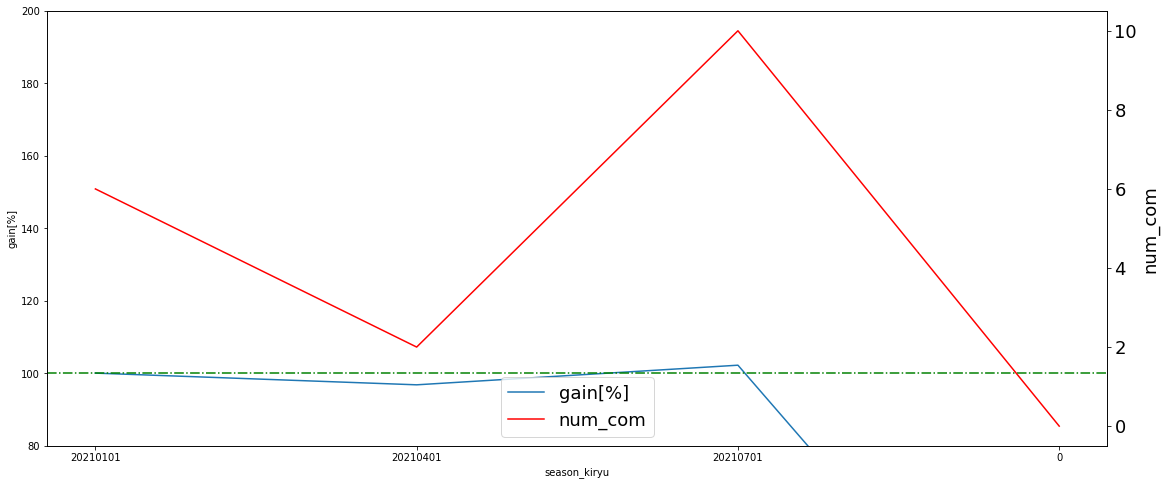

  4%|███▍                                                                               | 1/24 [00:00<00:06,  3.77it/s]

place_name: toda ========================================================================================
../bot_database/toda/model_score_toda/use_model/V4_2/use_model_toda_20210101_V4_2.csv
../bot_database/toda/model_score_toda/use_model/V4_2/use_model_toda_20210401_V4_2.csv
../bot_database/toda/model_score_toda/use_model/V4_2/use_model_toda_20210701_V4_2.csv


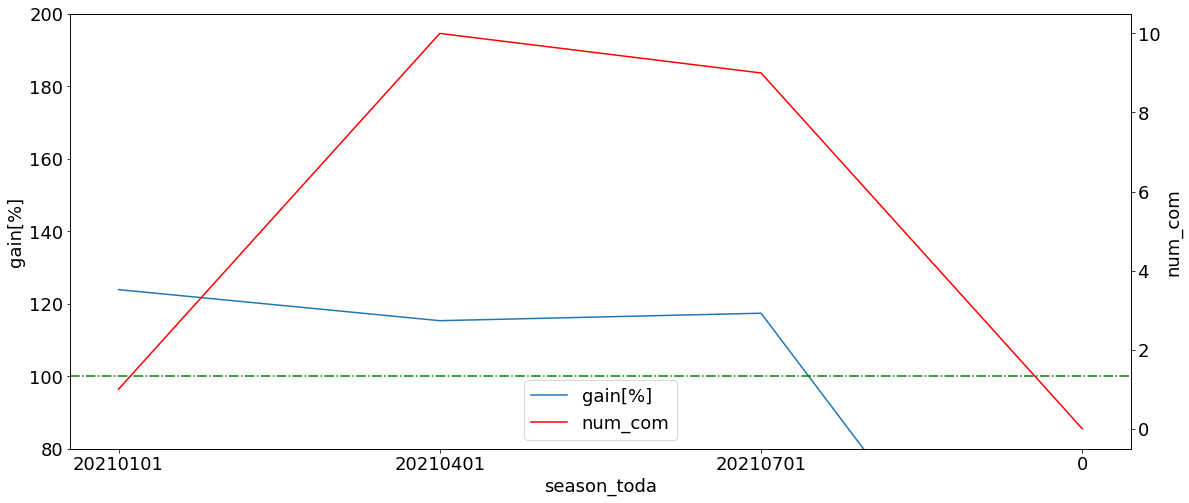

  8%|██████▉                                                                            | 2/24 [00:00<00:05,  4.21it/s]

place_name: edogawa ========================================================================================
../bot_database/edogawa/model_score_edogawa/use_model/V4_2/use_model_edogawa_20210101_V4_2.csv
../bot_database/edogawa/model_score_edogawa/use_model/V4_2/use_model_edogawa_20210401_V4_2.csv
../bot_database/edogawa/model_score_edogawa/use_model/V4_2/use_model_edogawa_20210701_V4_2.csv


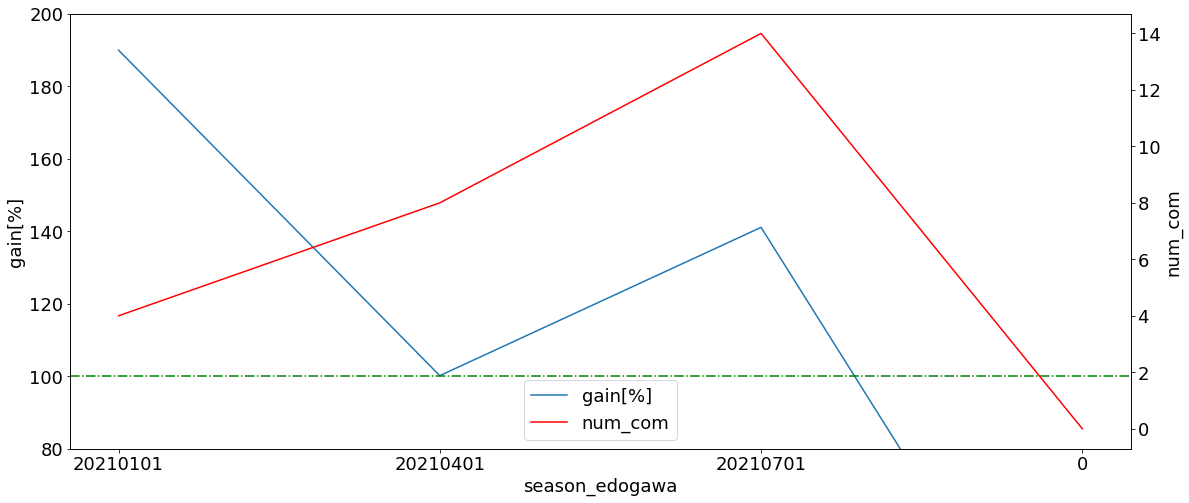

 12%|██████████▍                                                                        | 3/24 [00:00<00:04,  4.28it/s]

place_name: heiwazima ========================================================================================
../bot_database/heiwazima/model_score_heiwazima/use_model/V4_2/use_model_heiwazima_20210101_V4_2.csv
../bot_database/heiwazima/model_score_heiwazima/use_model/V4_2/use_model_heiwazima_20210401_V4_2.csv
../bot_database/heiwazima/model_score_heiwazima/use_model/V4_2/use_model_heiwazima_20210701_V4_2.csv


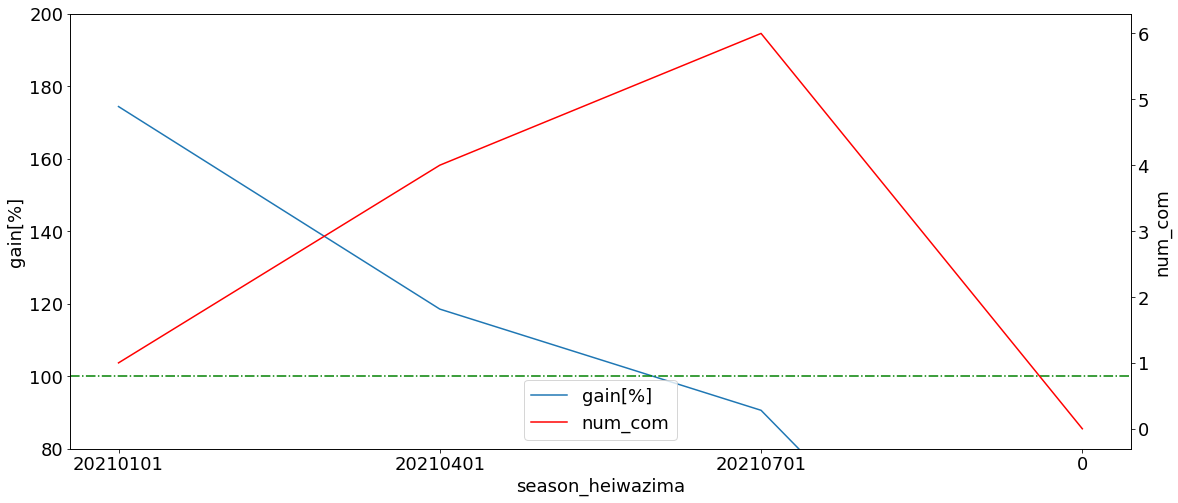

 17%|█████████████▊                                                                     | 4/24 [00:01<00:05,  3.72it/s]

place_name: tamagawa ========================================================================================
../bot_database/tamagawa/model_score_tamagawa/use_model/V4_2/use_model_tamagawa_20210101_V4_2.csv
../bot_database/tamagawa/model_score_tamagawa/use_model/V4_2/use_model_tamagawa_20210401_V4_2.csv
../bot_database/tamagawa/model_score_tamagawa/use_model/V4_2/use_model_tamagawa_20210701_V4_2.csv


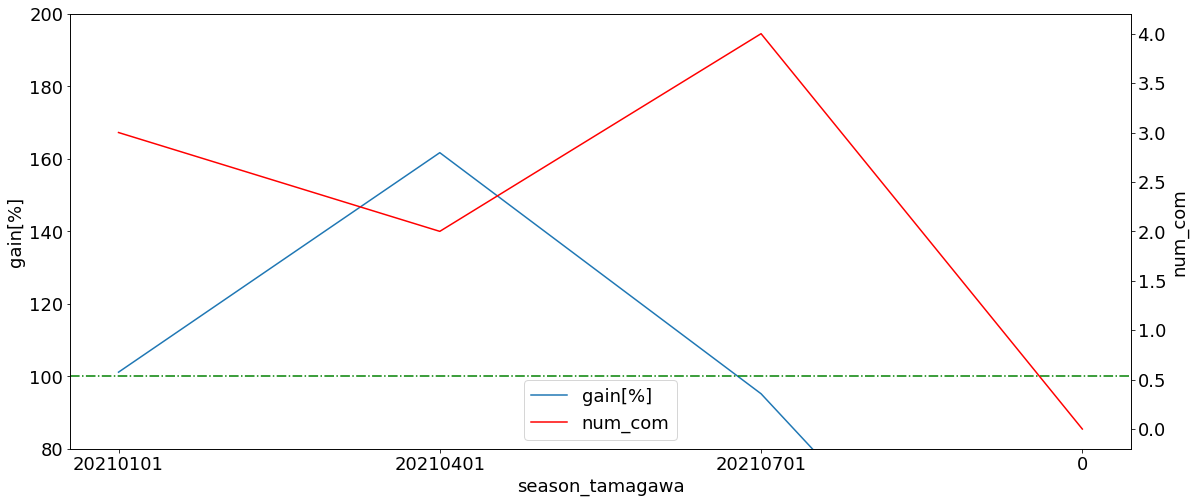

 21%|█████████████████▎                                                                 | 5/24 [00:01<00:04,  3.87it/s]

place_name: hamanako ========================================================================================
../bot_database/hamanako/model_score_hamanako/use_model/V4_2/use_model_hamanako_20210101_V4_2.csv
../bot_database/hamanako/model_score_hamanako/use_model/V4_2/use_model_hamanako_20210401_V4_2.csv
../bot_database/hamanako/model_score_hamanako/use_model/V4_2/use_model_hamanako_20210701_V4_2.csv


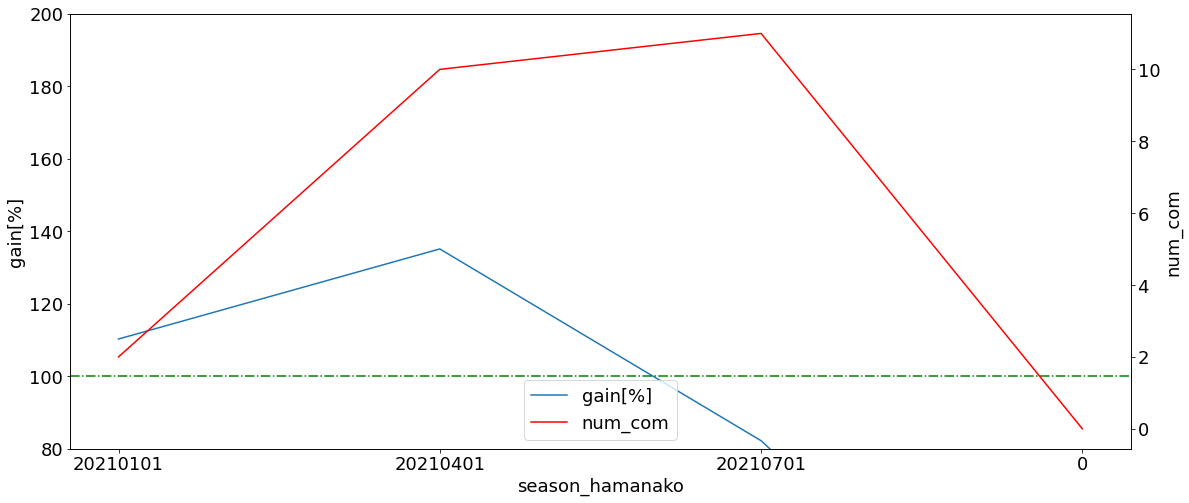

 25%|████████████████████▊                                                              | 6/24 [00:01<00:04,  4.06it/s]

place_name: gamagori ========================================================================================
../bot_database/gamagori/model_score_gamagori/use_model/V4_2/use_model_gamagori_20210101_V4_2.csv
../bot_database/gamagori/model_score_gamagori/use_model/V4_2/use_model_gamagori_20210401_V4_2.csv
../bot_database/gamagori/model_score_gamagori/use_model/V4_2/use_model_gamagori_20210701_V4_2.csv


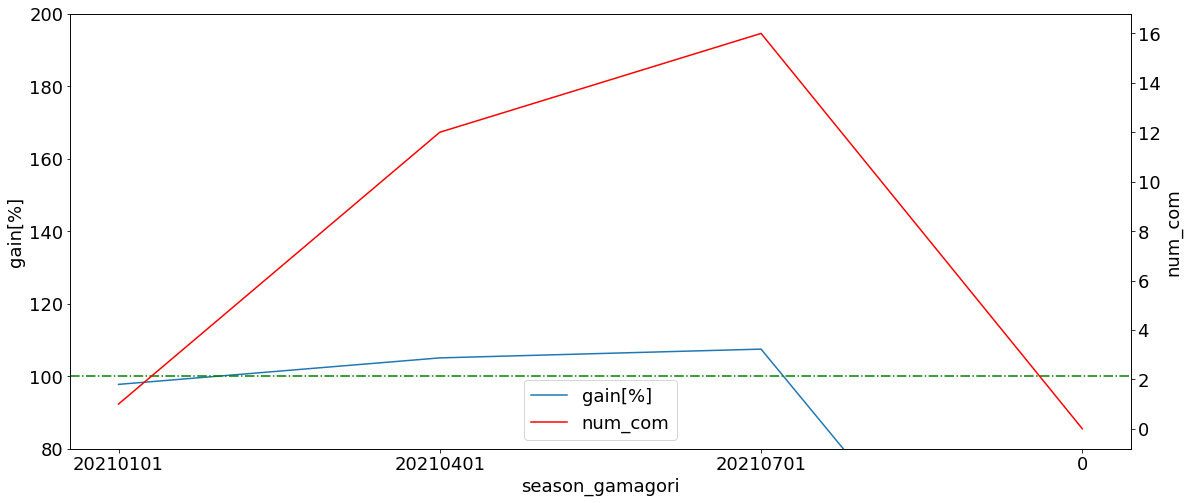

 29%|████████████████████████▏                                                          | 7/24 [00:01<00:04,  4.04it/s]

place_name: tokoname ========================================================================================
../bot_database/tokoname/model_score_tokoname/use_model/V4_2/use_model_tokoname_20210101_V4_2.csv
../bot_database/tokoname/model_score_tokoname/use_model/V4_2/use_model_tokoname_20210401_V4_2.csv
../bot_database/tokoname/model_score_tokoname/use_model/V4_2/use_model_tokoname_20210701_V4_2.csv


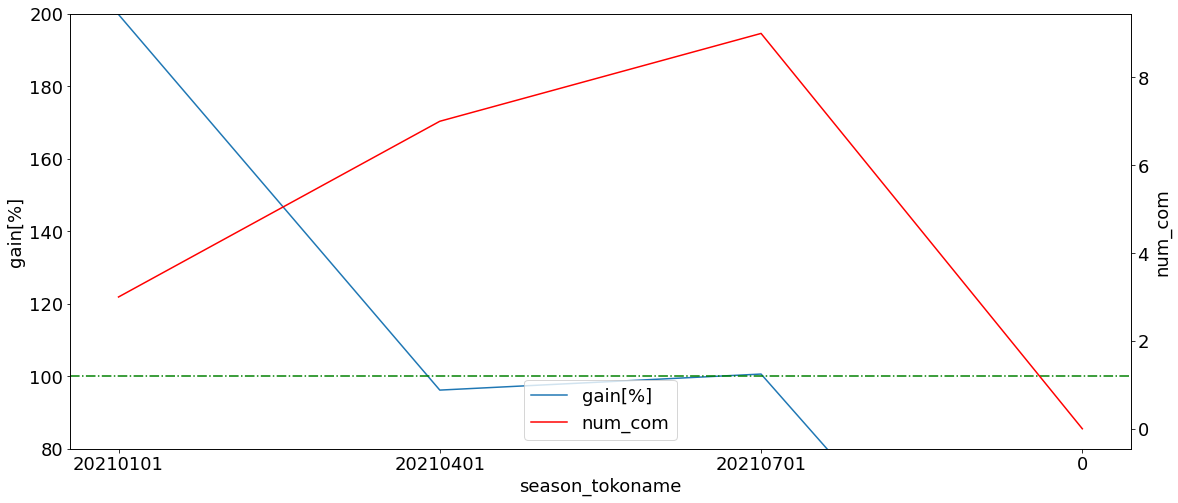

 33%|███████████████████████████▋                                                       | 8/24 [00:01<00:03,  4.17it/s]

place_name: tu ========================================================================================
../bot_database/tu/model_score_tu/use_model/V4_2/use_model_tu_20210101_V4_2.csv
../bot_database/tu/model_score_tu/use_model/V4_2/use_model_tu_20210401_V4_2.csv
../bot_database/tu/model_score_tu/use_model/V4_2/use_model_tu_20210701_V4_2.csv


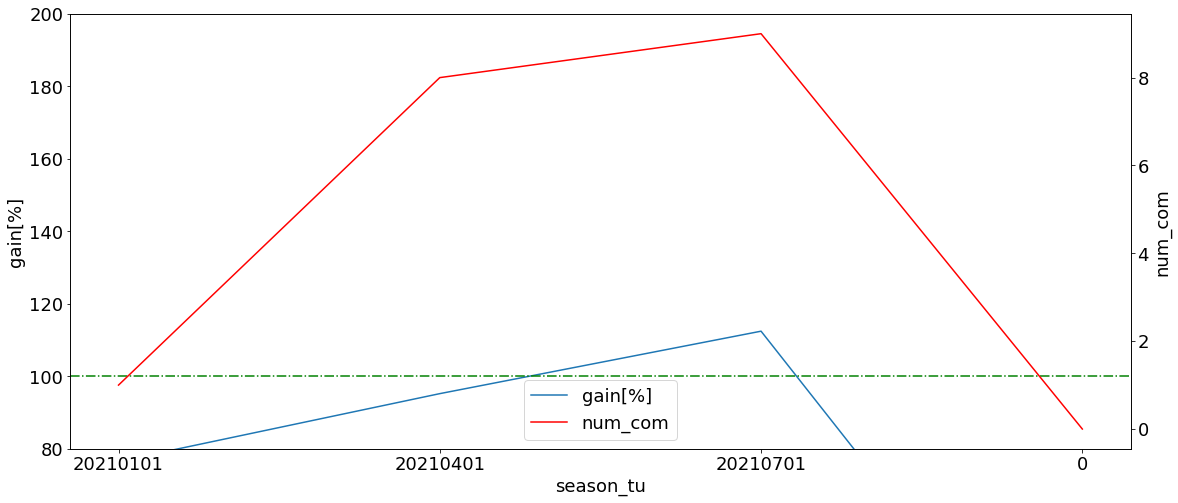

 38%|███████████████████████████████▏                                                   | 9/24 [00:02<00:03,  4.11it/s]

place_name: mikuni ========================================================================================
../bot_database/mikuni/model_score_mikuni/use_model/V4_2/use_model_mikuni_20210101_V4_2.csv
../bot_database/mikuni/model_score_mikuni/use_model/V4_2/use_model_mikuni_20210401_V4_2.csv
../bot_database/mikuni/model_score_mikuni/use_model/V4_2/use_model_mikuni_20210701_V4_2.csv


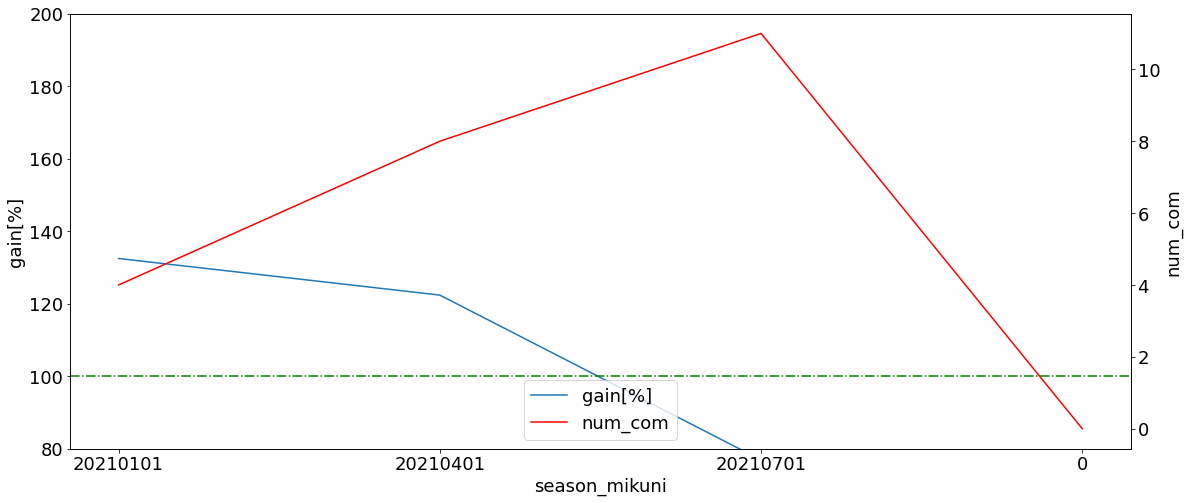

 42%|██████████████████████████████████▏                                               | 10/24 [00:02<00:03,  4.15it/s]

place_name: biwako ========================================================================================
../bot_database/biwako/model_score_biwako/use_model/V4_2/use_model_biwako_20210101_V4_2.csv
../bot_database/biwako/model_score_biwako/use_model/V4_2/use_model_biwako_20210401_V4_2.csv
../bot_database/biwako/model_score_biwako/use_model/V4_2/use_model_biwako_20210701_V4_2.csv


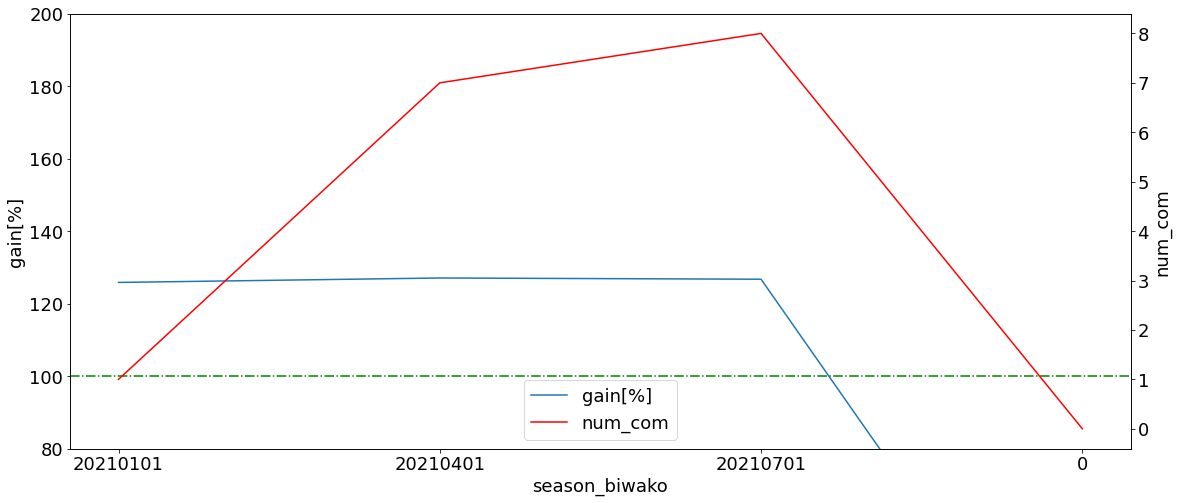

 46%|█████████████████████████████████████▌                                            | 11/24 [00:02<00:03,  4.06it/s]

place_name: suminoe ========================================================================================
../bot_database/suminoe/model_score_suminoe/use_model/V4_2/use_model_suminoe_20210101_V4_2.csv
../bot_database/suminoe/model_score_suminoe/use_model/V4_2/use_model_suminoe_20210401_V4_2.csv


FileNotFoundError: [Errno 2] No such file or directory: '../bot_database/suminoe/model_score_suminoe/use_model/V4_2/use_model_suminoe_20210401_V4_2.csv'

In [6]:
#today=datetime.date.today()#今日の日付の取得
today=datetime.datetime(year=2021, month=10,day=1)
now_date=today
version='V4_2'

for place_name in tqdm(place_names):
    print('place_name:',place_name,'========================================================================================')
    gain_arr=[0]*4
    n_com_arr=[0]*4
    date_arr=[0]*4
    diff_sec_dates=get_4_section_dt(now_date)#直近４区間の開始日をリストで取得
    now_date_txt=now_date.strftime('%Y%m%d')
    diff_sec_dates=diff_sec_dates[1:]#テスト時のみの特別処理！！データが１区間だけ足りないので今回はスルーする
    for i in range(len(diff_sec_dates)):
        sec_date=diff_sec_dates[i]
        sec_date_txt=sec_date.strftime('%Y%m%d')
        dir_path = "../bot_database/{place_name}/model_score_{place_name}/use_model/{version}/use_model_{place_name}_{now_ym}_{version}.csv".format(place_name=place_name,version=version,now_ym=sec_date_txt)#作成したデータの書き込み先#使用するデータの読み込み
        print(dir_path)
        use_models=pd.read_csv(dir_path, encoding='utf_8_sig')
        s_t_use=use_models['total_use_final'].sum()
        s_t_get=use_models['total_get_final'].sum()
        s_gain=(s_t_get/s_t_use)*100
        gain_arr[i]=s_gain
        n_com_arr[i]=len(use_models)
        date_arr[i]=sec_date_txt
    x_n='season_{place_name}'.format(place_name=place_name)
    y1_n='gain[%]'
    y2_n='num_com'
    twin_plt(date_arr,gain_arr,n_com_arr,x_n,y1_n,y2_n)

## 出力したパラメータシート(use_model)をもとにpickleにモデルを保存する

In [22]:
version='V4_2'#バージョン
#pickleの書き込み先作成のための箱作り
place_master=master.get_place_master()
for place in place_master.items():
    #print(place[0],place[1],'\n')
    place_name=place[1]
    dir_path = "../bot_database/{place_name}/model_pickle_{place_name}/{version}".format(place_name=place_name,version=version)#作成したデータの書き込み先#使用するデータの読み込み
    if os.path.exists(dir_path)==False:
        os.makedirs(dir_path)
    else:
        pass

In [23]:
def get_event_info(result_base_df):
    df=result_base_df.copy()
    df['date']=pd.to_datetime(df['date'])#日付が文字列なのでdateを日付型に変換
    df['year']=df['date'].dt.year
    df['month']=df['date'].dt.month
    df['day']=df['date'].dt.day

    num_date=1
    num_date_arr=[]
    last_race_date=df['date'].values[0]#前レースの日付(処理開始時用にtarainのデータの一番初めのdateを仮に入力しておく)
    for index,row in df.iterrows():
        today_date=row['date']
        if today_date==last_race_date:#同じ日のレースだったらおなじレース日を配列に追加、次の日の日付を出力（ほぼ無操作みたいなもん）
            next_date=row['date'] + datetime.timedelta(days=1)#次の日
            num_date_arr.append(num_date)
        else:#日にちが変わった時
            if today_date==next_date:#想定していた日付（次の日のレース）だったら,レース日を一日足して、そのレース日番号を加算
                num_date+=1
                num_date_arr.append(num_date)
                last_race_date=row['date']#前回レース日を上書き
                #next_date=train_df[train_df['date']==row['date'] + datetime.timedelta(days=1)]#次の日
                next_date=row['date'] + datetime.timedelta(days=1)#次の日
                #print(next_date)
            else:#想定していた日付でない(違う大会になった)場合はレース日をリセット
                num_date=1
                num_date_arr.append(num_date)
                last_race_date=row['date']#前回レース日を上書き
                #next_date=train_df[train_df['date']==row['date'] + datetime.timedelta(days=1)]#次の日
                next_date=row['date'] + datetime.timedelta(days=1)#次の日
    df['num_date']=num_date_arr

    range_races=0#大会中の取得できたレースの数
    range_date=1#大会の開催日数
    range_date_arr=[]
    range_date_arr_2=[]#for文中で繰り返し上書きさせる用の配列
    last_race_date=df['date'].values[0]#前レースの日付(処理開始時用にtrainのデータの一番初めのdateを仮に入力しておく)
    for index,row in df.iterrows():
        today_date=row['date']
        if today_date==last_race_date:#同じ日のレースだったらおなじレース日を配列に追加、次の日の日付を出力（ほぼ無操作みたいなもん）
            range_races+=1
            next_date=row['date'] + datetime.timedelta(days=1)#次の日
            #num_date_arr.append(num_date)
        else:#日にちが変わった時
            if today_date==next_date:#想定していた日付（次の日のレース）だったら,レース日を一日足して終了
                range_date+=1
                range_races+=1
                last_race_date=row['date']#前回レース日を上書き
                #next_date=train_df[train_df['date']==row['date'] + datetime.timedelta(days=1)]#次の日
                next_date=row['date'] + datetime.timedelta(days=1)#次の日次の日
            else:#想定していた日付でない(違う大会になった)場合は現在のrange_dateをもとに前の大会のレースに大会開催日数を持たせる。

                range_date_arr_2=[range_date]*range_races
                for num in range_date_arr_2:
                    range_date_arr.append(num)
                range_races=1#大会中の取得できたレースの数
                range_date=1#大会の開催日数
                last_race_date=row['date']#前回レース日を上書き
                #next_date=train_df[train_df['date']==row['date'] + datetime.timedelta(days=1)]#次の日
                next_date=row['date'] + datetime.timedelta(days=1)#次の日
    range_date_arr_2=[range_date]*range_races#最後の日は日付の変わり絵が発生しないので特別処理
    for num in range_date_arr_2:
        range_date_arr.append(num)
    df['range_date']=range_date_arr

    #四半期カラムの作成
    df['season']=df['month']
    df['season']=df['season'].replace([3,4,5],'sp')#春
    df['season']=df['season'].replace([6,7,8],'su')#夏
    df['season']=df['season'].replace([9,10,11],'au')#秋
    df['season']=df['season'].replace([12,1,2],'wi')#冬
    #df=df.drop('date',axis=1)
    return df

def pred_th_trans(pred_df,th):
    #引数として予測結果のdeと、変換したい閾値を渡す。
    trans_df=pred_df.copy()
    trans_df.loc[trans_df['pred_proba'] >= th, 'pred'] = 1
    trans_df.loc[~(trans_df['pred_proba']  >=  th), 'pred'] = 0
    return trans_df

def calc_monthly_analysis(pred_df):#予測に加えて，配当，開催情報が結合されたdfを渡すことで月ごと関連の分析を行ってくれる関数
    cols=['month','use','get','income','income_per','num_hit','buy_hit_per','mean_income','median_income']
    monthly_analysis_df= pd.DataFrame(columns=cols)#月別収益結果の入る箱
    months=pred_df['month'].value_counts(sort=False).index
    for month in months:
        monthly_df=pred_df[pred_df['month']==month].copy()
        use_m=100*monthly_df['pred'].sum()
        get_m=monthly_df['gain'].sum()
        income=get_m-use_m
        income_per=(get_m/use_m)*100
        
        
        num_hit=monthly_df['hit_flag'].sum()
        num_pred=pred_df['pred'].sum()
        buy_hit_per=(num_hit/num_pred)*100
        if num_hit==0:#警告文削除用
            mean_income=0
            median_income=0
        else:
            mean_income=monthly_df[monthly_df['hit_flag']==1]["gain"].mean()#１回の的中あたりの平均配当
            median_income=monthly_df[monthly_df['hit_flag']==1]["gain"].median()#１回の的中あたりの中央配当
        
        append_arr=[month,use_m,get_m,income,income_per,num_hit,buy_hit_per,mean_income,median_income]
        append_s=pd.Series(append_arr,index=cols)
        monthly_analysis_df=monthly_analysis_df.append(append_s, ignore_index=True)
    return monthly_analysis_df

def get_season_date(now_date):#日付(datetime型)を渡すと，その日付で購買予測を行う際に使用するデータの区間を返す関数
    use_data_year=now_date.year
    if (now_date.month>=1)and(now_date.month<4):
        use_data_month=1
    elif (now_date.month>=4)and(now_date.month<7):
        use_data_month=4
    elif (now_date.month>=7)and(now_date.month<10):
        use_data_month=7
    elif (now_date.month>=10):
        use_data_month=10
    else:
        print('what???????')
    use_data_date=datetime.datetime(year=use_data_year, month=use_data_month,day=1)
    return use_data_date
def trans_result_com(target_com,trans_base_df):#comをターゲットに合わせて0,1の二値に変換する。
    #学習データのラベル変換==========================================================
    trans_df=trans_base_df.copy()
    #result_train_df=trans_base_df.copy()
    result_arr=[0]*len(trans_df)
    i=0
    for result in trans_df['result_com']:#
        if ((result==target_com)):
            result_arr[i]=1
        else:
            result_arr[i]=0
        i+=1
    trans_df['result_com']=result_arr
    return trans_df

def pred_th_trans(pred_df,th):#引数として予測結果のdeと、変換したい閾値を渡す。

    trans_df=pred_df.copy()
    trans_df.loc[trans_df['pred_proba'] >= th, 'pred'] = 1
    trans_df.loc[~(trans_df['pred_proba']  >=  th), 'pred'] = 0
    return trans_df

def pred_th_trans_com(pred_df,th,target_com):#指定の組のカラムのみを置換。
    trans_df=pred_df.copy()
    trans_df.loc[trans_df['pred_{}'.format(target_com)] >= th, 'pred_{}'.format(target_com)] = 1
    trans_df.loc[~(trans_df['pred_{}'.format(target_com)] >=  th), 'pred_{}'.format(target_com)] = 0
    return trans_df

def calc_gain(pred_gain_df):#レース単位であたっているか同課の判別と、当たった場合に得られた配当金を計算する関数
    pred_true_df=pred_gain_df[(pred_gain_df['pred']==1)&(pred_gain_df['trans_result']==1)].copy()
    pred_true_df['hit']=1
    calc_base_df=pred_gain_df.copy()
    calc_base_df['hit']=pred_true_df['hit']
    calc_base_df['gain']=pred_true_df['money']
    calc_base_df=calc_base_df.fillna(0)
    #
    #calc_base_df:予測、変換積みの結果、実際の結果、配当金、収益をすべて表したdf,合計操作は行っていない。
    #
    return calc_base_df

def check_pred_arr(pred1_df,pred2_df):#カラムの中身が同じか比較する関数
    pred_1_vals=[pred1_df[col] for col in pred1_df.columns]
    pred_2_vals=[pred2_df[col] for col in pred2_df.columns]
    for col_name1,col1,col_name2,col2 in zip(pred1_df.columns,pred_1_vals,pred2_df.columns,pred_2_vals):
        if list(col1.values)==list(col1.values):
            print(col_name1,'  and  ',col_name2,'  is same pred \n')
    return None

def pred_th_trans(pred_df,th):#閾値を渡して、その値以上を1、未満を0に置き変える。
    #引数として予測結果のdeと、変換したい閾値を渡す。
    trans_df=pred_df.copy()
    trans_df.loc[trans_df['pred_proba'] >= th, 'pred'] = 1
    trans_df.loc[~(trans_df['pred_proba']  >=  th), 'pred'] = 0
    return trans_df

def add_result_class(model,score_df):#モデルでの予測結果を学習時に使用したパラメータシートに追加して返す関数
    #out_figはオプション、グラフの出力の有り無し
    score_sheet_base=score_df.copy()
    score_sheet_shuffle=score_sheet_base.sample(frac=1, random_state=7)#行をシャッフル
    num_data=len(score_sheet_shuffle)#データの件数

    #前処理    これはクラス分類なので閾値で最新収益を1,0に変換する
    score_sheet_shuffle['gain_label']=0#実際の収益の有無を確認(110を利益有り無しの閾値とする )
    score_sheet_shuffle.loc[score_sheet_shuffle['gain_year3'] < 110, 'gain_label'] =0
    score_sheet_shuffle.loc[score_sheet_shuffle['gain_year3'] >= 110, 'gain_label'] =1
    ex_df=score_sheet_shuffle.copy()#gain_year3の切り抜き用
    score_sheet_shuffle=score_sheet_shuffle.drop(['gain_year3'],axis=1).copy()

    #データの分割========================================================================================================
    test_df = score_sheet_shuffle[int(num_data*0.8):].copy()#20%のデータを検証用データに。
    train_df =  score_sheet_shuffle[:int(num_data*0.8)].copy()#そのほかを学習データに
    gain_s=ex_df[int(num_data*0.8):]['gain_year3'].copy()#検証用データの実収益部分を切り抜く。

    test_x=test_df.drop(['gain_label'],axis=1).copy()
    train_x=train_df.drop(['gain_label'],axis=1).copy()
    test_y=test_df['gain_label']
    train_y=train_df['gain_label']
    test_pred_df=test_df.copy()#予測の結合先を作っておく
    train_pred_df=train_df.copy()#予測の結合先を作っておく

    #予測を出力(確率分布)
    train_pred_proba_arr=model.predict_proba(train_x)
    train_pred_proba=[arr[1] for arr in train_pred_proba_arr]#確率分布の二次元配列なので[1]の部分だけ取り出す
    test_pred_proba_arr = model.predict_proba(test_x)
    test_pred_proba=[arr[1] for arr in test_pred_proba_arr]#確率分布の二次元配列なので[1]の部分だけ取り出す
    test_pred_df["pred_proba"]=test_pred_proba#予測を結合
    train_pred_df["pred_proba"]=train_pred_proba#予測を結合

    #確率分布の閾値で予測をバイナリに変換(仮)
    #test_pred_df=pred_th_trans(test_pred_df,0.5)
    #train_pred_df=pred_th_trans(train_pred_df,0.5)

#     #モデルのスコアの計算
#     col1='pred'
#     col2='gain_label'
#     cross_df,train_precision=making_cross(col1,col2 ,train_pred_df)
#     cross_df,test_precision=making_cross(col1,col2 ,test_pred_df)
#     print("train_precision:{}__test_precision:{}".format(train_precision,test_precision))

    test_pred_df['gain_year3']=gain_s#実際の収益の情報を追加する
    return test_pred_df

def making_cross(col1,col2,base_df,out_cross=0):#クロス収益図を作成してpurecisionを算出する関数
    cross_df=pd.DataFrame(columns=["{}_1".format(col2),"{}_0".format(col2),'sum']
                         ,index=["{}_1".format(col1),"{}_0".format(col1),'sum'])#クロス集計の結果の格納df
    cross_df.at["{}_1".format(col1), "{}_1".format(col2)]=len(base_df[(base_df[col1]==1) & (base_df[col2]==1)])#左上
    cross_df.at["{}_1".format(col1), "{}_0".format(col2)]=len(base_df[(base_df[col1]==1) & (base_df[col2]==0)])#右上
    cross_df.at["{}_0".format(col1), "{}_1".format(col2)]=len(base_df[(base_df[col1]==0) & (base_df[col2]==1)])#左下
    cross_df.at["{}_0".format(col1), "{}_0".format(col2)]=len(base_df[(base_df[col1]==0) & (base_df[col2]==0)])#右下

    cross_df.at["{}_1".format(col1), "sum"]=cross_df.at["{}_1".format(col1), "{}_1".format(col2)]+cross_df.at["{}_1".format(col1), "{}_0".format(col2)]
    cross_df.at["{}_0".format(col1), "sum"]=cross_df.at["{}_0".format(col1), "{}_1".format(col2)]+cross_df.at["{}_0".format(col1), "{}_0".format(col2)]
    cross_df.at["sum", "{}_1".format(col2)]=cross_df.at["{}_1".format(col1), "{}_1".format(col2)]+cross_df.at["{}_0".format(col1), "{}_1".format(col2)]
    cross_df.at["sum", "{}_0".format(col2)]=cross_df.at["{}_1".format(col1), "{}_0".format(col2)]+cross_df.at["{}_0".format(col1), "{}_0".format(col2)]
    if out_cross==1:
        display(cross_df)
    #precisionを算出
    try:
        #precision=(cross_df.at["{}_1".format(col1), "{}_1".format(col2)]/(cross_df.at["{}_1".format(col1), "{}_1".format(col2)]+cross_df.at["{}_1".format(col1), "{}_0".format(col2)]))*100
        precision=(cross_df.at["{}_1".format(col1), "{}_1".format(col2)]/(cross_df.at["{}_1".format(col1),'sum']))*100
    except ZeroDivisionError:
        precision=0

    return cross_df,precision

In [24]:
def data_making_clustar_section_has_final(df,now_ym,range_test_m,range_final_m):#モデル関連に使用するdfの作成関数(クラスタリングあり、モータ番号、艇番号なし)（加工関数）final(実運用バックテスト区間)あり版
    #V4系列で使用する加工関数，年と月の情報を使って直近のデータを使って性能検証を行う（区間を使ってデータを作っている）
    #validデータを作成するバージョンなので実装する際はこれをそのまま使わず，final_test部分の処理は消してくだちい
    #yearが使わないと思うけど一応残してあるから邪魔だと思ったら消して下さい
    result_df=df
    result_df=result_df.drop(["racer_1_ID","racer_2_ID","racer_3_ID","racer_4_ID","racer_5_ID","racer_6_ID",],axis=1)#IDはいらないので削除
    result_df=result_df.replace(0.0000,{"racer_1_ave_st_time":0.22}).copy()#新人のave_st_timeを0.22に
    result_df=result_df.replace(0.0000,{"racer_2_ave_st_time":0.22}).copy()
    result_df=result_df.replace(0.0000,{"racer_3_ave_st_time":0.22}).copy()
    result_df=result_df.replace(0.0000,{"racer_4_ave_st_time":0.22}).copy()
    result_df=result_df.replace(0.0000,{"racer_5_ave_st_time":0.22}).copy()
    result_df=result_df.replace(0.0000,{"racer_6_ave_st_time":0.22}).copy()
    result_df=result_df.replace(0.0000,{"racer_1_doub_win":0.02}).copy()#新人の着に絡む確率ave_st_timeを0.02に(新人の半期の偏差から導出)
    result_df=result_df.replace(0.0000,{"racer_2_doub_win":0.02}).copy()
    result_df=result_df.replace(0.0000,{"racer_3_doub_win":0.02}).copy()
    result_df=result_df.replace(0.0000,{"racer_4_doub_win":0.02}).copy()
    result_df=result_df.replace(0.0000,{"racer_5_doub_win":0.02}).copy()
    result_df=result_df.replace(0.0000,{"racer_6_doub_win":0.02}).copy()

    #result_base_df=result_df.copy()
    #result_base_df=get_event_info(result_base_df)#開催の情報について付与する関数(年月日に加えて，何日間の開催かどうかも教えてくれる)

    #ダミー変数化
    result_df_dummie=result_df.copy()
    race_dummie_df=pd.get_dummies(result_df_dummie['number_race'])#number_raceをダミー化
    for column, val in race_dummie_df.iteritems():
        result_df_dummie['race_{}'.format(int(column))]=val
    result_df_dummie=result_df_dummie.drop('number_race',axis=1).copy()

    cols=list(result_df_dummie.columns)
    male_cols=[s for s in cols if 'male' in s]#性別を示すカラムを取り出す

    #===========================新規、性別の取り出し機能が良くなかったため作り直す
    empty_arr=[0]*len(result_df_dummie)
    for col in male_cols:
        for number in np.arange(0,2,1):
              result_df_dummie['{}_{}'.format(col,int(number))]=empty_arr.copy()
        male_dummie_df=pd.get_dummies(result_df_dummie[col]).copy()#性別をダミー化
        for column, val in male_dummie_df.iteritems():
              result_df_dummie['{}_{}'.format(col,int(column))]=val.copy()
        result_df_dummie=result_df_dummie.drop('{}'.format(col),axis=1).copy()

    cols=list(result_df_dummie.columns)



    moter_cols=[s for s in cols if '_mo' in s]#モーター番号を示すカラムを取り出す
    boat_cols=[s for s in cols if '_bo' in s]#ボート番号を示すカラムを取り出す

    #boat、moterの情報は使わない、
    numbers=np.arange(1, 100, 1)
    empty_arr=[0]*len(result_df_dummie)
    for col in moter_cols:
        result_df_dummie=result_df_dummie.drop('{}'.format(col),axis=1).copy()
    for col in boat_cols:
        result_df_dummie=result_df_dummie.drop('{}'.format(col),axis=1).copy()

    #クラスタリング
    #分けてみるクラスタの数は[3,5,7,9]の4個
    #cluster_target_df　　trainのデータからリザルトと配当金を取り除いたもの
    #学習データのdateを年に変換
    result_df_dummie['date']=pd.to_datetime(result_df_dummie['date'])#日付が文字列なのでdateを日付型に変換
    result_df_dummie['year']=result_df_dummie['date'].dt.year
    
    #==========================================================================
    #result_df_dummie=result_df_dummie[result_df_dummie['year']!=2020].copy()#2020のデータを完全に切り離す。
    #==========================================================================
    #クラアスタリング用の学習、予測用のデータの切り分け
    #年，月，日とかの取得
    #now_ym:開始の月
    test_st_date = now_ym - relativedelta(months=range_test_m)#テストデータに使用する区間を決める
    final_test_en_date = now_ym + relativedelta(months=range_final_m)#最終テストの終了日
    
    clustar_final_test_df=result_df_dummie[(result_df_dummie['date']>=now_ym) & (result_df_dummie['date']<final_test_en_date) ].copy()#今の日付以降を最終チェックデータ(予測のターゲット)に。
    clustar_test_df = result_df_dummie[(result_df_dummie['date']<now_ym) & ((result_df_dummie['date']>=test_st_date) )].copy()#今日に日より前の，指定した区間でのテストデータ
    clustar_train_df =  result_df_dummie[(result_df_dummie['date']<test_st_date)].copy()#そのほかを学習データに
    result_df_dummie=result_df_dummie[result_df_dummie['date']<final_test_en_date]
    #年の情報だけ切り分けに使ったからここで消す。
    clustar_final_test_df=clustar_final_test_df.drop('date',axis=1).copy()
    clustar_test_df=clustar_test_df.drop('date',axis=1).copy()
    clustar_train_df=clustar_train_df.drop('date',axis=1).copy()

    #クラスタリングに邪魔だから消したいけど、後々使うものはいったんよけておく
    result=result_df_dummie['result_com'].values.copy()#
    money=result_df_dummie['money'].values.copy()#
    years=result_df_dummie['year'].values.copy()#
    dates=result_df_dummie['date'].values.copy()#
    
    #安全なところに移したら削除する
    result_df_dummie=result_df_dummie.drop('result_com',axis=1)
    result_df_dummie=result_df_dummie.drop('money',axis=1)
    result_df_dummie=result_df_dummie.drop('year',axis=1)
    #esult_df_dummie=result_df_dummie.drop('date',axis=1)
    
    

    target_num_cluster=[3,5,7,9]#分けるクラスタ数によってモデルの名前を変える
    for num_cluster in target_num_cluster:
        Km = KMeans(random_state=7,n_clusters=num_cluster).fit(clustar_train_df)#rondom_stateはラッキーセブン
        #final_test_pred =Km.predict(clustar_final_test_df)#rondom_stateはラッキーセブン
        final_test_pred =Km.predict(clustar_final_test_df)#rondom_stateはラッキーセブン
        test_pred =Km.predict(clustar_test_df)#rondom_stateはラッキーセブン
        train_pred = Km.predict(clustar_train_df)#rondom_stateはラッキーセブン
        #Km=========================実査に使うときはこれのモデルを会場ごとに保存して使用。
        #clustar_final_test_df['num={}'.format(num_cluster)]=final_test_pred
        clustar_final_test_df['num={}'.format(num_cluster)]=final_test_pred
        clustar_test_df['num={}'.format(num_cluster)]=test_pred
        clustar_train_df['num={}'.format(num_cluster)]=train_pred

    #結合して元の形に戻す。
    #clustar_df=pd.concat([clustar_train_df, clustar_test_df,clustar_final_test_df]).copy()
#     clustar_final_test_df['check']='final'#確認用
#     clustar_test_df['check']='test'#確認用
#     clustar_train_df['check']='train'#確認用
    clustar_df=pd.concat([clustar_train_df, clustar_test_df,clustar_final_test_df]).copy()
    clustar_df['year']=years
    clustar_df['date']=dates
    clustar_df['money']=money
    clustar_df['result_com']=result
    model_df=clustar_df.copy()
    return model_df

def data_making_clustar_section(df,now_ym,range_test_m):#モデル関連に使用するdfの作成関数(クラスタリングあり、モータ番号、艇番号なし)（加工関数）final(実運用バックテスト区間)無し版
    #V4系列で使用する加工関数，年と月の情報を使って直近のデータを使って性能検証を行う（区間を使ってデータを作っている）
    #validデータを作成するバージョンなので実装する際はこれをそのまま使わず，final_test部分の処理は消してくだちい
    #yearが使わないと思うけど一応残してあるから邪魔だと思ったら消して下さい
    result_df=df
    result_df=result_df.drop(["racer_1_ID","racer_2_ID","racer_3_ID","racer_4_ID","racer_5_ID","racer_6_ID",],axis=1)#IDはいらないので削除
    result_df=result_df.replace(0.0000,{"racer_1_ave_st_time":0.22}).copy()#新人のave_st_timeを0.22に
    result_df=result_df.replace(0.0000,{"racer_2_ave_st_time":0.22}).copy()
    result_df=result_df.replace(0.0000,{"racer_3_ave_st_time":0.22}).copy()
    result_df=result_df.replace(0.0000,{"racer_4_ave_st_time":0.22}).copy()
    result_df=result_df.replace(0.0000,{"racer_5_ave_st_time":0.22}).copy()
    result_df=result_df.replace(0.0000,{"racer_6_ave_st_time":0.22}).copy()
    result_df=result_df.replace(0.0000,{"racer_1_doub_win":0.02}).copy()#新人の着に絡む確率ave_st_timeを0.02に(新人の半期の偏差から導出)
    result_df=result_df.replace(0.0000,{"racer_2_doub_win":0.02}).copy()
    result_df=result_df.replace(0.0000,{"racer_3_doub_win":0.02}).copy()
    result_df=result_df.replace(0.0000,{"racer_4_doub_win":0.02}).copy()
    result_df=result_df.replace(0.0000,{"racer_5_doub_win":0.02}).copy()
    result_df=result_df.replace(0.0000,{"racer_6_doub_win":0.02}).copy()

    #result_base_df=result_df.copy()
    #result_base_df=get_event_info(result_base_df)#開催の情報について付与する関数(年月日に加えて，何日間の開催かどうかも教えてくれる)

    #ダミー変数化
    result_df_dummie=result_df.copy()
    race_dummie_df=pd.get_dummies(result_df_dummie['number_race'])#number_raceをダミー化
    for column, val in race_dummie_df.iteritems():
        result_df_dummie['race_{}'.format(int(column))]=val
    result_df_dummie=result_df_dummie.drop('number_race',axis=1).copy()

    cols=list(result_df_dummie.columns)
    male_cols=[s for s in cols if 'male' in s]#性別を示すカラムを取り出す

    #===========================新規、性別の取り出し機能が良くなかったため作り直す
    empty_arr=[0]*len(result_df_dummie)
    for col in male_cols:
        for number in np.arange(0,2,1):
              result_df_dummie['{}_{}'.format(col,int(number))]=empty_arr.copy()
        male_dummie_df=pd.get_dummies(result_df_dummie[col]).copy()#性別をダミー化
        for column, val in male_dummie_df.iteritems():
              result_df_dummie['{}_{}'.format(col,int(column))]=val.copy()
        result_df_dummie=result_df_dummie.drop('{}'.format(col),axis=1).copy()

    cols=list(result_df_dummie.columns)



    moter_cols=[s for s in cols if '_mo' in s]#モーター番号を示すカラムを取り出す
    boat_cols=[s for s in cols if '_bo' in s]#ボート番号を示すカラムを取り出す

    #boat、moterの情報は使わない、
    numbers=np.arange(1, 100, 1)
    empty_arr=[0]*len(result_df_dummie)
    for col in moter_cols:
        result_df_dummie=result_df_dummie.drop('{}'.format(col),axis=1).copy()
    for col in boat_cols:
        result_df_dummie=result_df_dummie.drop('{}'.format(col),axis=1).copy()

    #クラスタリング
    #分けてみるクラスタの数は[3,5,7,9]の4個
    #cluster_target_df　　trainのデータからリザルトと配当金を取り除いたもの
    #学習データのdateを年に変換
    result_df_dummie['date']=pd.to_datetime(result_df_dummie['date'])#日付が文字列なのでdateを日付型に変換
    result_df_dummie['year']=result_df_dummie['date'].dt.year
    
    #==========================================================================
    #result_df_dummie=result_df_dummie[result_df_dummie['year']!=2020].copy()#2020のデータを完全に切り離す。
    #==========================================================================
    #クラアスタリング用の学習、予測用のデータの切り分け
    #年，月，日とかの取得
    #now_ym:開始の月
    test_st_date = now_ym - relativedelta(months=range_test_m)#テストデータに使用する区間を決める
    #final_test_en_date = now_ym + relativedelta(months=range_final_m)#最終テストの終了日
    
    #clustar_final_test_df=result_df_dummie[(result_df_dummie['date']>=now_ym) & (result_df_dummie['date']<final_test_en_date) ].copy()#今の日付以降を最終チェックデータ(予測のターゲット)に。
    clustar_test_df = result_df_dummie[(result_df_dummie['date']<now_ym) & ((result_df_dummie['date']>=test_st_date) )].copy()#今日より前の，指定した区間でのテストデータ
    clustar_train_df =  result_df_dummie[(result_df_dummie['date']<test_st_date)].copy()#そのほかを学習データに
    result_df_dummie=result_df_dummie[result_df_dummie['date']<now_ym]
    #年の情報だけ切り分けに使ったからここで消す。
    #clustar_final_test_df=clustar_final_test_df.drop('date',axis=1).copy()
    clustar_test_df=clustar_test_df.drop('date',axis=1).copy()
    clustar_train_df=clustar_train_df.drop('date',axis=1).copy()

    #クラスタリングに邪魔だから消したいけど、後々使うものはいったんよけておく
    result=result_df_dummie['result_com'].values.copy()#
    money=result_df_dummie['money'].values.copy()#
    years=result_df_dummie['year'].values.copy()#
    dates=result_df_dummie['date'].values.copy()#
    
    #安全なところに移したら削除する
    result_df_dummie=result_df_dummie.drop('result_com',axis=1)
    result_df_dummie=result_df_dummie.drop('money',axis=1)
    result_df_dummie=result_df_dummie.drop('year',axis=1)
    #esult_df_dummie=result_df_dummie.drop('date',axis=1)
    
    

    target_num_cluster=[3,5,7,9]#分けるクラスタ数によってモデルの名前を変える
    for num_cluster in target_num_cluster:
        Km = KMeans(random_state=7,n_clusters=num_cluster).fit(clustar_train_df)#rondom_stateはラッキーセブン
        #final_test_pred =Km.predict(clustar_final_test_df)#rondom_stateはラッキーセブン
        test_pred =Km.predict(clustar_test_df)#rondom_stateはラッキーセブン
        train_pred = Km.predict(clustar_train_df)#rondom_stateはラッキーセブン
        #Km=========================実査に使うときはこれのモデルを会場ごとに保存して使用。
        #clustar_final_test_df['num={}'.format(num_cluster)]=final_test_pred
        #clustar_final_test_df['num={}'.format(num_cluster)]=final_test_pred
        clustar_test_df['num={}'.format(num_cluster)]=test_pred
        clustar_train_df['num={}'.format(num_cluster)]=train_pred

    #結合して元の形に戻す。
    #clustar_df=pd.concat([clustar_train_df, clustar_test_df,clustar_final_test_df]).copy()
#     clustar_final_test_df['check']='final'#確認用
#     clustar_test_df['check']='test'#確認用
#     clustar_train_df['check']='train'#確認用
    #clustar_df=pd.concat([clustar_train_df, clustar_test_df,clustar_final_test_df]).copy()
    clustar_df=pd.concat([clustar_train_df, clustar_test_df]).copy()
    clustar_df['year']=years
    clustar_df['date']=dates
    clustar_df['money']=money
    clustar_df['result_com']=result
    model_df=clustar_df.copy()
    return model_df

def model_score_rondom_th_section_has_final(version,place_name,result_df,now_ym,range_test_m,range_final_m):#rondomforestの出力を確率のやつを使用したバージョン、閾値の探索も行う。final(実運用バックテスト区間)あり版＿＿※[注意]ここでのnow_ymは区間の開始日を示していて，今日の日付ではないことに注意
    print(place_name)
    #result_dfは加工関数にて分けられたものを渡す。
    model_score_df=pd.DataFrame(columns=['target_com','depth','target_per','threshold','total_get_test', 'total_use_test','num_com_test','num_pred_test','gain_test','gain_std_test','num_hit_test','buy_hit_per_test','buy_hit_per_std_test','plus_month_num_test','diff_mea_med_test','total_get_final', 'total_use_final','num_com_final','num_pred_final','gain_final','gain_std_final','num_hit_final','buy_hit_per_final','buy_hit_per_std_final','plus_month_num_final','diff_mea_med_final'])#スコアを格納するdf

    #学習データの切り分け
    #年，月，日とかの取得
    #now_ym:開始の月
    test_st_date = now_ym - relativedelta(months=range_test_m)#テストデータに使用する区間を決める
    final_test_en_date = now_ym + relativedelta(months=range_final_m)#最終テストの終了日
    #以下学習データ
    final_test_df=result_df[(result_df['date']>=now_ym) & (result_df['date']<final_test_en_date) ].copy()#今の日付以降を最終チェックデータ(予測のターゲット)に。
    test_df = result_df[(result_df['date']<now_ym) & ((result_df['date']>=test_st_date) )].copy()#今日に日より前の，指定した区間でのテストデータ
    train_df =  result_df[(result_df['date']<test_st_date)].copy()#そのほかを学習データに

    #V4ではdateは性能評価用のdf作成時に使用するので別でとっておく(最終的にtransしたpredのdfに結合する)
    final_test_dates=final_test_df['date'].values
    test_dates=test_df['date'].values
    train_dates=train_df['date'].values

    #学習データを切り分けたらyearはいらないから削除する
    final_test_df=final_test_df.drop(['year'],axis=1)
    test_df=test_df.drop(['year'],axis=1)
    train_df=train_df.drop(['year'],axis=1)
    final_test_df=final_test_df.drop(['date'],axis=1)
    test_df=test_df.drop(['date'],axis=1)
    train_df=train_df.drop(['date'],axis=1)

    train_money=pd.Series(train_df['money'])
    test_money=pd.Series(test_df['money'])
    final_test_money=pd.Series(final_test_df['money'])
    test_gain_arr=test_money.values
    final_test_gain_arr=final_test_money.values
    #x,yへの切り分け
    #出現数の分布
    result_com_s=test_df['result_com'].value_counts()
    result_com_s=result_com_s.sort_index()
    gain_mean=test_df.groupby('result_com')['money'].mean()
    gain_mean=gain_mean.sort_index()

    gain_median=test_df.groupby('result_com')['money'].median()
    gain_median=gain_median.sort_index()
    result_com_df=pd.DataFrame({'result_com':result_com_s.index,
                                'result_com_num':result_com_s.values,
                                'result_com_per':result_com_s.values/sum(result_com_s.values)*100,
                                'gain_mean':gain_mean.values,
                                'gain_median':gain_median.values,})
    result_com_df=result_com_df.iloc[0:28]#探索的に探すにも最後のほうは役にモデルなのはわかっているため




    for result_com_number in tqdm(result_com_df['result_com'].values):
        #print(result_com_number)
        result_com=result_com_number
        #result_comごとの閾値の決定========================================================================

        gain_th=10#利益率の閾値
        result_s=result_com_df[result_com_df['result_com']==result_com]
        buy_accuracy_th=result_s['result_com_per'].values[0]*1.1#買ったうちの的中率の閾値
        num_tp_th=result_s['result_com_num'].values[0]*0.2#あたった回数の閾値(出現回数の20%が的中)
        #===============================================================================
        #学習データのラベル変換==========================================================
        result_train_df=train_df.copy()
        result_arr=[0]*len(result_train_df)
        i=0
        for result in result_train_df['result_com']:
            if ((result==result_com)):
                result_arr[i]=1
            else:
                result_arr[i]=0
            i+=1
        result_train_df['result_com']=result_arr

        target_test_df=test_df.copy()
        result_arr=[0]*len(target_test_df)
        i=0
        for result in target_test_df['result_com']:
            if ((result==result_com)):
                result_arr[i]=1
            else:
                result_arr[i]=0
            i+=1
        target_test_df['result_com']=result_arr

        target_final_test_df=final_test_df.copy()
        result_arr=[0]*len(target_final_test_df)
        i=0
        for result in target_final_test_df['result_com']:
            if ((result==result_com)):
                result_arr[i]=1
            else:
                result_arr[i]=0
            i+=1
        target_final_test_df['result_com']=result_arr

        result_train_df['money']=train_money
        target_test_df['money']=test_money
        target_final_test_df['money']=final_test_money
        #学習データラベル変換終わり============================================

        for_arr=np.arange(1,85)
        #for_arr=np.arange(1,100,1)
        accuracy_arr=[0]*len(for_arr)
        target_per_arr=[0]*len(for_arr)
        pred_0=[0]*len(for_arr)
        gain_arr=[0]*len(for_arr)
        model_gain_arr=[0]*len(target_test_df)
        #depths_arr=[4,5,6,7,8]
        #depths_arr=[5,6,8]
        depths_arr=[5,7]
        for depth in depths_arr:
            for sum_target_per in for_arr:

                index=sum_target_per-1
                #target_per=50+sum_target_per
                target_per=80+(sum_target_per)
                target_per_arr[index]=target_per

                #モデルの評価指標値を格納するseries======================
                model_score_s=pd.Series(index=['target_com','depth','target_per','threshold','total_get_test', 'total_use_test','num_com_test','num_pred_test','gain_test','gain_std_test','num_hit_test','buy_hit_per_test','buy_hit_per_std_test','plus_month_num_test','diff_mea_med_test','total_get_final', 'total_use_final','num_com_final','num_pred_final','gain_final','gain_std_final','num_hit_final','buy_hit_per_final','buy_hit_per_std_final','plus_month_num_final','diff_mea_med_final'], dtype='float64')
                model_score_s['target_com']=result_com#目標としているresult_comラベル番号
                model_score_s['depth']=depth#ハイパーパラメータ＿木の深さ
                model_score_s['target_per']=target_per#学習データ_1に対してどの程度の0のデータを持たせるか。
                #======================
                #trainの[0]に対して、target_perの割合の量[1]を持った学習データの作成
                # 一層目の判別機のtrainデータ　:terget_result_df
                target_df=result_train_df#ベースのデータフレームをコピー
                target_df=target_df.sample(frac=1, random_state=7)#シャッフル、時系列の偏りを無くす
                target_1_df=target_df[target_df['result_com']==1]
                len_1=len(target_1_df)
                target_0_df=target_df[target_df['result_com']==0]
                len_0=len(target_0_df)
                target_0_df=target_0_df.iloc[(len_0-int(len_1*(target_per/100))):len_0]#1に対する目標の割合ぶん0の結果だったレースを抽出（後ろから抽出）
                target_train_df=pd.concat([target_1_df, target_0_df])
                #学習＆予測ぱーと========================================================================
                #==========================================================================================================================================
                #データの切り分け
                target_x_train=target_train_df.drop('money',axis=1).copy()
                target_x_train=target_x_train.drop('result_com',axis=1)

                target_x_test=target_test_df.drop('money',axis=1).copy()
                target_x_test=target_x_test.drop('result_com',axis=1)

                target_x_final=target_final_test_df.drop('money',axis=1).copy()
                target_x_final=target_x_final.drop('result_com',axis=1)

                target_y_train=target_train_df['result_com']
                target_y_test=target_test_df['result_com']
                target_y_final=target_final_test_df['result_com']
                train_x, valid_x, train_y, valid_y = train_test_split(target_x_train, target_y_train, test_size=0.2, shuffle=True, random_state=7)#学習データ内でさらに分割してロスをもとに修正をする。

                #XGboostのデータ型に変換する
#                 train = xgb.DMatrix(train_x, label=train_y)#学習用
#                 valid = xgb.DMatrix(valid_x, label=valid_y)#学習時のロス修正用
#                 test = xgb.DMatrix(target_x_test, label=target_y_test)#実際に使った時の利益率の算出用
#                 final = xgb.DMatrix(target_x_final, label=target_y_final)#最終確認用の区間

                #RF = RandomForestClassifier(random_state=7,n_estimators=1000,max_depth=depth,n_jobs=5)
                RF = RandomForestClassifier(random_state=7,n_estimators=1000,max_depth=depth,n_jobs=1)
                
                RF = RF.fit(target_x_train,target_y_train)
                #bst = xgb.train(param, train,num_round,evallist, verbose=100,early_stopping_rounds=30 )
                #RF = RandomForestClassifier(random_state=1,n_estimators=1000,max_depth=depth)
                #RF = RF.fit(target_x_train,target_y_train)


                # 未知データに対する予測値
                #predict_y_test = RF.predict(target_x_test)
#                 predict_y_test=bst.predict(test)
#                 predict_y_final=bst.predict(final)
                predict_y_test_proba_arr = RF.predict_proba(target_x_test)#まだ多次元リスト
                predict_y_test=[proba_arr[1] for proba_arr in predict_y_test_proba_arr]#1にあたる部分の確率のみ出力
                predict_y_final_proba_arr = RF.predict_proba(target_x_final)#まだ多次元リスト
                predict_y_final=[proba_arr[1] for proba_arr in predict_y_final_proba_arr]#1にあたる部分の確率のみ出力
                #==========================================================================================================================================
                #==========================================================================================================================================
                #==========================================================================================================================================
                #==========================================================================================================================================

                #[1]の正答率を見る
                pred_test_df=pd.DataFrame({'pred_proba':predict_y_test#確率分布での出力
                                          , 'test':target_y_test})
                pred_final_test_df=pd.DataFrame({'pred_proba':predict_y_final#確率分布での出力
                                          , 'test':target_y_final})


                th_arr=[0.5,0.54,0.58]
                for th in th_arr:
                    trans_test_df=pred_th_trans(pred_test_df,th)
                    trans_final_test_df=pred_th_trans(pred_final_test_df,th)
                    #num_1=len(trans_df[trans_df['test']==1])
                    #追加　配当金の情報も考慮する。
                    count_test=0
                    gain_index=0
                    model_test_gain_arr=[0]*len(test_df)
                    test_hit_arr=[0]*len(test_df)#あたっているかあたっていないかのフラグを格納した配列
                    for _, s in trans_test_df.iterrows():
                        if ((s['pred']==1) and (s['test']==1)):#もし購買しているかつ的中をしていたら・・・
                            count_test+=1#的中回数
                            model_test_gain_arr[gain_index]=test_gain_arr[gain_index]
                            test_hit_arr[gain_index]=1
                        gain_index+=1

                    count_final=0
                    gain_index=0
                    model_final_test_gain_arr=[0]*len(final_test_df)
                    final_test_hit_arr=[0]*len(final_test_df)#あたっているかあたっていないかのフラグを格納した配列
                    for _, s in trans_final_test_df.iterrows():
                        if ((s['pred']==1) and (s['test']==1)):#もし購買しているかつ的中をしていたら・・・
                            count_final+=1#的中回数
                            model_final_test_gain_arr[gain_index]=final_test_gain_arr[gain_index]
                            final_test_hit_arr[gain_index]=1
                        gain_index+=1

    #                     gain_arr[index]=sum(model_gain_arr)
    #                     accuracy_arr[index]=(count/num_1)*100
                    #=================================================
                    try:
                        pred_0[index]=trans_df['pred'].value_counts()[0]
                    except:
                        pred_0[index]=0

                    #V4から増やした集計(月での集計を加えて，comごとでの安定性について確認する)
                    test_analysis_df=trans_test_df.copy()#集計結果を格納するためのdf
                    final_test_analysis_df=trans_final_test_df.copy()#集計結果を格納するためのdf
                    #集計のための情報を結合する
                    test_analysis_df['hit_flag']=test_hit_arr#的中時に１のフラグを結合する
                    test_analysis_df['gain']=model_test_gain_arr#的中して得られたゲインの金額を格納した配列
                    test_analysis_df['date']=test_dates#月ごとの分析のために日付のデータを結合する
                    test_analysis_df=get_event_info(test_analysis_df)#開催情報を取得

                    final_test_analysis_df['hit_flag']=final_test_hit_arr#的中時に１のフラグを結合する
                    final_test_analysis_df['gain']=model_final_test_gain_arr#的中して得られたゲインの金額を格納した配列
                    final_test_analysis_df['date']=final_test_dates#月ごとの分析のために日付のデータを結合する
                    final_test_analysis_df=get_event_info(final_test_analysis_df)#開催情報を取得

                    test_m_analysis=calc_monthly_analysis(test_analysis_df)#月別の分析結果を取得
                    final_test_m_analysis=calc_monthly_analysis(final_test_analysis_df)#月別の分析結果を取得
                    test_m_desc=test_m_analysis.describe()
                    final_test_m_desc=final_test_m_analysis.describe()
                    #scoreのseriesに情報書き込み==================
                    model_score_s['threshold']=th
                    #テストデータ=============================================================
                    #総収益
                    model_score_s['total_get_test']=sum(model_test_gain_arr)
                    #投資金額
                    model_score_s['total_use_test']=100*trans_test_df['pred'].sum()
                    #出現数
                    model_score_s['num_com_test']=sum(target_y_test)
                    #購買予測数
                    model_score_s['num_pred_test']=trans_test_df['pred'].sum()
                    #利益率
                    model_score_s['gain_test']=(model_score_s['total_get_test']/model_score_s['total_use_test'])*100
                    #利益率の標準偏差
                    model_score_s['gain_std_test']=test_m_desc.loc['std','income_per']
                    #的中数
                    model_score_s['num_hit_test']=count_test
                    #購買的中率
                    model_score_s['buy_hit_per_test']=(count_test/trans_test_df['pred'].sum())*100
                    #購買的中率の標準偏差
                    model_score_s['buy_hit_per_std_test']=test_m_desc.loc['std','buy_hit_per']
                    #配当がプラスになった月の数
                    model_score_s['plus_month_num_test']=len(test_m_analysis[test_m_analysis['income']>0])
                    #得られた配当の中央値と平均の差(中央値-平均，つまりマイナスが大きいほど高い配当が引っ張っている)
                    model_score_s['diff_mea_med_test']=(test_m_desc.loc['mean','mean_income'])-(test_m_desc.loc['mean','median_income'])

                    #最終テストデータ(カラム名の説明に関してはテストと同じなので割愛させていただきます)=============================================================
                    model_score_s['total_get_final']=sum(model_final_test_gain_arr)
                    model_score_s['total_use_final']=100*trans_final_test_df['pred'].sum()
                    model_score_s['num_com_final']=sum(target_y_final)
                    model_score_s['num_pred_final']=trans_final_test_df['pred'].sum()
                    model_score_s['gain_final']=(model_score_s['total_get_final']/model_score_s['total_use_final'])*100
                    model_score_s['gain_std_final']=final_test_m_desc.loc['std','income_per']

                    model_score_s['num_hit_final']=count_final
                    model_score_s['buy_hit_per_final']=(count_final/trans_final_test_df['pred'].sum())*100
                    model_score_s['buy_hit_per_std_final']=final_test_m_desc.loc['std','buy_hit_per']
                    model_score_s['plus_month_num_final']=len(final_test_m_analysis[final_test_m_analysis['income']>0])
                    model_score_s['diff_mea_med_final']=(final_test_m_desc.loc['mean','mean_income'])-(final_test_m_desc.loc['mean','median_income'])

                    #dfに書き込み
                    model_score_df=model_score_df.append(model_score_s,ignore_index=True)
    #モデルの「スコアを保存
    #dir_path = "../../bot_database/{place_name}/model_score_{place_name}/v4_score/{V}/{place_name}_model_score_st{stDate}_finalM{finalM}_{V}.csv".format(place_name=place_name,V=version,stDate=now_ym.strftime('%Y%m%d'),finalM=range_final_m)#作成したデータの書き込み先#使用するデータの読み込み
    dir_path = "../../../bot_database/{place_name}/model_score_{place_name}/v4_score/{V}/{place_name}_model_score_st{stDate}_finalM{finalM}_{V}.csv".format(place_name=place_name,V=version,stDate=now_ym.strftime('%Y%m%d'),finalM=range_final_m)#作成したデータの書き込み先#使用するデータの読み込み
    
    model_score_df.to_csv(dir_path, encoding='utf_8_sig')
    return None

def model_score_rondom_th_section(version,place_name,result_df,now_ym,range_test_m):#rondomforestの出力を確率のやつを使用したバージョン、閾値の探索も行う。final(実運用バックテスト区間)無し版__※[注意]ここでのnow_ymは区間の開始日を示していて，今日の日付ではないことに注意
    print(place_name)
    #result_dfは加工関数にて分けられたものを渡す。
    model_score_df=pd.DataFrame(columns=['target_com','depth','target_per','threshold','total_get_test', 'total_use_test','num_com_test','num_pred_test','gain_test','gain_std_test','num_hit_test','buy_hit_per_test','buy_hit_per_std_test','plus_month_num_test','diff_mea_med_test'])#スコアを格納するdf

    #学習データの切り分け
    #年，月，日とかの取得
    #now_ym:開始の月
    test_st_date = now_ym - relativedelta(months=range_test_m)#テストデータに使用する区間を決める
    #final_test_en_date = now_ym + relativedelta(months=range_final_m)#最終テストの終了日
    #以下学習データ
    #final_test_df=result_df[(result_df['date']>=now_ym) & (result_df['date']<final_test_en_date) ].copy()#今の日付以降を最終チェックデータ(予測のターゲット)に。
    test_df = result_df[(result_df['date']<now_ym) & ((result_df['date']>=test_st_date) )].copy()#今日に日より前の，指定した区間でのテストデータ
    train_df =  result_df[(result_df['date']<test_st_date)].copy()#そのほかを学習データに
    #V4ではdateは性能評価用のdf作成時に使用するので別でとっておく(最終的にtransしたpredのdfに結合する)
    #final_test_dates=final_test_df['date'].values
    test_dates=test_df['date'].values
    train_dates=train_df['date'].values

    #学習データを切り分けたらyearはいらないから削除する
    #final_test_df=final_test_df.drop(['year'],axis=1)
    test_df=test_df.drop(['year'],axis=1)
    train_df=train_df.drop(['year'],axis=1)
    #final_test_df=final_test_df.drop(['date'],axis=1)
    test_df=test_df.drop(['date'],axis=1)
    train_df=train_df.drop(['date'],axis=1)

    train_money=pd.Series(train_df['money'])
    test_money=pd.Series(test_df['money'])
    #final_test_money=pd.Series(final_test_df['money'])
    test_gain_arr=test_money.values
    #final_test_gain_arr=final_test_money.values
    #x,yへの切り分け
    #出現数の分布
    result_com_s=test_df['result_com'].value_counts()
    result_com_s=result_com_s.sort_index()
    gain_mean=test_df.groupby('result_com')['money'].mean()
    gain_mean=gain_mean.sort_index()

    gain_median=test_df.groupby('result_com')['money'].median()
    gain_median=gain_median.sort_index()
    result_com_df=pd.DataFrame({'result_com':result_com_s.index,
                                'result_com_num':result_com_s.values,
                                'result_com_per':result_com_s.values/sum(result_com_s.values)*100,
                                'gain_mean':gain_mean.values,
                                'gain_median':gain_median.values,})
    result_com_df=result_com_df.iloc[0:28]#探索的に探すにも最後のほうは役にモデルなのはわかっているため
    for result_com_number in tqdm(result_com_df['result_com'].values):
        #print(result_com_number)
        result_com=result_com_number
        #result_comごとの閾値の決定========================================================================

        gain_th=10#利益率の閾値
        result_s=result_com_df[result_com_df['result_com']==result_com]
        buy_accuracy_th=result_s['result_com_per'].values[0]*1.1#買ったうちの的中率の閾値
        num_tp_th=result_s['result_com_num'].values[0]*0.2#あたった回数の閾値(出現回数の20%が的中)
        #===============================================================================
        #学習データのラベル変換==========================================================
        result_train_df=train_df.copy()
        result_arr=[0]*len(result_train_df)
        i=0
        for result in result_train_df['result_com']:
            if ((result==result_com)):
                result_arr[i]=1
            else:
                result_arr[i]=0
            i+=1
        result_train_df['result_com']=result_arr

        target_test_df=test_df.copy()
        result_arr=[0]*len(target_test_df)
        i=0
        for result in target_test_df['result_com']:
            if ((result==result_com)):
                result_arr[i]=1
            else:
                result_arr[i]=0
            i+=1
        target_test_df['result_com']=result_arr

#         target_final_test_df=final_test_df.copy()
#         result_arr=[0]*len(target_final_test_df)
#         i=0
#         for result in target_final_test_df['result_com']:
#             if ((result==result_com)):
#                 result_arr[i]=1
#             else:
#                 result_arr[i]=0
#             i+=1
#         target_final_test_df['result_com']=result_arr

        result_train_df['money']=train_money
        target_test_df['money']=test_money
        #target_final_test_df['money']=final_test_money
        #学習データラベル変換終わり============================================

        for_arr=np.arange(1,85)
        #for_arr=np.arange(1,100,1)
        accuracy_arr=[0]*len(for_arr)
        target_per_arr=[0]*len(for_arr)
        pred_0=[0]*len(for_arr)
        gain_arr=[0]*len(for_arr)
        model_gain_arr=[0]*len(target_test_df)
        #depths_arr=[4,5,6,7,8]
        #depths_arr=[5,6,8]
        depths_arr=[5,7]
        for depth in depths_arr:
            for sum_target_per in for_arr:

                index=sum_target_per-1
                #target_per=50+sum_target_per
                target_per=80+(sum_target_per)
                target_per_arr[index]=target_per

                #モデルの評価指標値を格納するseries======================
                #final区間がない用のseries
                model_score_s=pd.Series(index=['target_com','depth','target_per','threshold','total_get_test', 'total_use_test','num_com_test','num_pred_test','gain_test','gain_std_test','num_hit_test','buy_hit_per_test','buy_hit_per_std_test','plus_month_num_test','diff_mea_med_test'], dtype='float64')
                model_score_s['target_com']=result_com#目標としているresult_comラベル番号
                model_score_s['depth']=depth#ハイパーパラメータ＿木の深さ
                model_score_s['target_per']=target_per#学習データ_1に対してどの程度の0のデータを持たせるか。
                #======================
                #trainの[0]に対して、target_perの割合の量[1]を持った学習データの作成
                # 一層目の判別機のtrainデータ　:terget_result_df
                target_df=result_train_df#ベースのデータフレームをコピー
                target_df=target_df.sample(frac=1, random_state=7)#シャッフル、時系列の偏りを無くす
                target_1_df=target_df[target_df['result_com']==1]
                len_1=len(target_1_df)
                target_0_df=target_df[target_df['result_com']==0]
                len_0=len(target_0_df)
                target_0_df=target_0_df.iloc[(len_0-int(len_1*(target_per/100))):len_0]#1に対する目標の割合ぶん0の結果だったレースを抽出（後ろから抽出）
                target_train_df=pd.concat([target_1_df, target_0_df])
                #学習＆予測ぱーと========================================================================
                #==========================================================================================================================================
                #データの切り分け
                target_x_train=target_train_df.drop('money',axis=1).copy()
                target_x_train=target_x_train.drop('result_com',axis=1)

                target_x_test=target_test_df.drop('money',axis=1).copy()
                target_x_test=target_x_test.drop('result_com',axis=1)

                #target_x_final=target_final_test_df.drop('money',axis=1).copy()
                #target_x_final=target_x_final.drop('result_com',axis=1)

                target_y_train=target_train_df['result_com']
                target_y_test=target_test_df['result_com']
                #target_y_final=target_final_test_df['result_com']
                train_x, valid_x, train_y, valid_y = train_test_split(target_x_train, target_y_train, test_size=0.2, shuffle=True, random_state=7)#学習データ内でさらに分割してロスをもとに修正をする。

                #XGboostのデータ型に変換する
#                 train = xgb.DMatrix(train_x, label=train_y)#学習用
#                 valid = xgb.DMatrix(valid_x, label=valid_y)#学習時のロス修正用
#                 test = xgb.DMatrix(target_x_test, label=target_y_test)#実際に使った時の利益率の算出用
#                 final = xgb.DMatrix(target_x_final, label=target_y_final)#最終確認用の区間
                #RF = RandomForestClassifier(random_state=7,n_estimators=1000,max_depth=depth,n_jobs=5)
                RF = RandomForestClassifier(random_state=7,n_estimators=1000,max_depth=depth,n_jobs=1)
                RF = RF.fit(target_x_train,target_y_train)
                #bst = xgb.train(param, train,num_round,evallist, verbose=100,early_stopping_rounds=30 )
                #RF = RandomForestClassifier(random_state=1,n_estimators=1000,max_depth=depth)
                #RF = RF.fit(target_x_train,target_y_train)


                # 未知データに対する予測値
                #predict_y_test = RF.predict(target_x_test)
#                 predict_y_test=bst.predict(test)
#                 predict_y_final=bst.predict(final)
                predict_y_test_proba_arr = RF.predict_proba(target_x_test)#まだ多次元リスト
                predict_y_test=[proba_arr[1] for proba_arr in predict_y_test_proba_arr]#1にあたる部分の確率のみ出力
                #predict_y_final_proba_arr = RF.predict_proba(target_x_final)#まだ多次元リスト
                #predict_y_final=[proba_arr[1] for proba_arr in predict_y_final_proba_arr]#1にあたる部分の確率のみ出力
                #==========================================================================================================================================
                #==========================================================================================================================================
                #==========================================================================================================================================
                #==========================================================================================================================================

                #[1]の正答率を見る
                pred_test_df=pd.DataFrame({'pred_proba':predict_y_test#確率分布での出力
                                          , 'test':target_y_test})
                #pred_final_test_df=pd.DataFrame({'pred_proba':predict_y_final#確率分布での出力
                #                          , 'test':target_y_final})


                th_arr=[0.5,0.54,0.58]
                for th in th_arr:
                    trans_test_df=pred_th_trans(pred_test_df,th)
                    #trans_final_test_df=pred_th_trans(pred_final_test_df,th)
                    #num_1=len(trans_df[trans_df['test']==1])
                    #追加　配当金の情報も考慮する。
                    count_test=0
                    gain_index=0
                    model_test_gain_arr=[0]*len(test_df)
                    test_hit_arr=[0]*len(test_df)#あたっているかあたっていないかのフラグを格納した配列
                    for _, s in trans_test_df.iterrows():
                        if ((s['pred']==1) and (s['test']==1)):#もし購買しているかつ的中をしていたら・・・
                            count_test+=1#的中回数
                            model_test_gain_arr[gain_index]=test_gain_arr[gain_index]
                            test_hit_arr[gain_index]=1
                        gain_index+=1

#                     count_final=0
#                     gain_index=0
#                     model_final_test_gain_arr=[0]*len(final_test_df)
#                     final_test_hit_arr=[0]*len(final_test_df)#あたっているかあたっていないかのフラグを格納した配列
#                     for _, s in trans_final_test_df.iterrows():
#                         if ((s['pred']==1) and (s['test']==1)):#もし購買しているかつ的中をしていたら・・・
#                             count_final+=1#的中回数
#                             model_final_test_gain_arr[gain_index]=final_test_gain_arr[gain_index]
#                             final_test_hit_arr[gain_index]=1
#                         gain_index+=1
    #                     gain_arr[index]=sum(model_gain_arr)
    #                     accuracy_arr[index]=(count/num_1)*100
                    #=================================================
                    try:
                        pred_0[index]=trans_df['pred'].value_counts()[0]
                    except:
                        pred_0[index]=0

                    #V4から増やした集計(月での集計を加えて，comごとでの安定性について確認する)
                    test_analysis_df=trans_test_df.copy()#集計結果を格納するためのdf
                    #final_test_analysis_df=trans_final_test_df.copy()#集計結果を格納するためのdf
                    #集計のための情報を結合する
                    test_analysis_df['hit_flag']=test_hit_arr#的中時に１のフラグを結合する
                    test_analysis_df['gain']=model_test_gain_arr#的中して得られたゲインの金額を格納した配列
                    test_analysis_df['date']=test_dates#月ごとの分析のために日付のデータを結合する
                    test_analysis_df=get_event_info(test_analysis_df)#開催情報を取得
#                     final_test_analysis_df['hit_flag']=final_test_hit_arr#的中時に１のフラグを結合する
#                     final_test_analysis_df['gain']=model_final_test_gain_arr#的中して得られたゲインの金額を格納した配列
#                     final_test_analysis_df['date']=final_test_dates#月ごとの分析のために日付のデータを結合する
#                     final_test_analysis_df=get_event_info(final_test_analysis_df)#開催情報を取得

                    test_m_analysis=calc_monthly_analysis(test_analysis_df)#月別の分析結果を取得
                    #final_test_m_analysis=calc_monthly_analysis(final_test_analysis_df)#月別の分析結果を取得
                    test_m_desc=test_m_analysis.describe()
                    #final_test_m_desc=final_test_m_analysis.describe()
                    #scoreのseriesに情報書き込み==================
                    model_score_s['threshold']=th
                    #テストデータ=============================================================
                    #総収益
                    model_score_s['total_get_test']=sum(model_test_gain_arr)
                    #投資金額
                    model_score_s['total_use_test']=100*trans_test_df['pred'].sum()
                    #出現数
                    model_score_s['num_com_test']=sum(target_y_test)
                    #購買予測数
                    model_score_s['num_pred_test']=trans_test_df['pred'].sum()
                    #利益率
                    model_score_s['gain_test']=(model_score_s['total_get_test']/model_score_s['total_use_test'])*100
                    #利益率の標準偏差
                    model_score_s['gain_std_test']=test_m_desc.loc['std','income_per']
                    #的中数
                    model_score_s['num_hit_test']=count_test
                    #購買的中率
                    model_score_s['buy_hit_per_test']=(count_test/trans_test_df['pred'].sum())*100
                    #購買的中率の標準偏差
                    model_score_s['buy_hit_per_std_test']=test_m_desc.loc['std','buy_hit_per']
                    #配当がプラスになった月の数
                    model_score_s['plus_month_num_test']=len(test_m_analysis[test_m_analysis['income']>0])
                    #得られた配当の中央値と平均の差(中央値-平均，つまりマイナスが大きいほど高い配当が引っ張っている)
                    model_score_s['diff_mea_med_test']=(test_m_desc.loc['mean','mean_income'])-(test_m_desc.loc['mean','median_income'])

                    #最終テストデータ(カラム名の説明に関してはテストと同じなので割愛させていただきます)=============================================================
#                     model_score_s['total_get_final']=sum(model_final_test_gain_arr)
#                     model_score_s['total_use_final']=100*trans_final_test_df['pred'].sum()
#                     model_score_s['num_com_final']=sum(target_y_final)
#                     model_score_s['num_pred_final']=trans_final_test_df['pred'].sum()
#                     model_score_s['gain_final']=(model_score_s['total_get_final']/model_score_s['total_use_final'])*100
#                     model_score_s['gain_std_final']=final_test_m_desc.loc['std','income_per']
#                     model_score_s['num_hit_final']=count_final
#                     model_score_s['buy_hit_per_final']=(count_final/trans_final_test_df['pred'].sum())*100
#                     model_score_s['buy_hit_per_std_final']=final_test_m_desc.loc['std','buy_hit_per']
#                     model_score_s['plus_month_num_final']=len(final_test_m_analysis[final_test_m_analysis['income']>0])
#                     model_score_s['diff_mea_med_final']=(final_test_m_desc.loc['mean','mean_income'])-(final_test_m_desc.loc['mean','median_income'])

                    #dfに書き込み
                    model_score_df=model_score_df.append(model_score_s,ignore_index=True)
    #モデルの「スコアを保存
    dir_path = "../../../bot_database/{place_name}/model_score_{place_name}/v4_score/{V}/{place_name}_model_score_st{stDate}_{V}.csv".format(place_name=place_name,V=version,stDate=now_ym.strftime('%Y%m%d'))#作成したデータの書き込み先#使用するデータの読み込み
    model_score_df.to_csv(dir_path, encoding='utf_8_sig')
    return None


## V4_2で作成した保存関数

In [36]:
def save_model_V4_2(range_test_m,result_base_df,use_model_df,now_sec_date,place_name,version):#random_forest_時系列データに注力
    print('place_name:',place_name,'========================================================================================')
    now_ym=now_sec_date
    result_df=data_making_clustar_section_pickle(range_test_m,result_base_df,now_sec_date,place_name,version)
    #result_dfは加工関数にて分けられたものを渡す。
    model_score_df=pd.DataFrame(columns=['target_com','depth','target_per','threshold','total_get_test', 'total_use_test','num_com_test','num_pred_test','gain_test','gain_std_test','num_hit_test','buy_hit_per_test','buy_hit_per_std_test','plus_month_num_test','diff_mea_med_test'])#スコアを格納するdf

    #学習データの切り分け
    #年，月，日とかの取得
    #now_ym:開始の月
    test_st_date = now_ym - relativedelta(months=range_test_m)#テストデータに使用する区間を決める
    #final_test_en_date = now_ym + relativedelta(months=range_final_m)#最終テストの終了日
    #以下学習データ
    #final_test_df=result_df[(result_df['date']>=now_ym) & (result_df['date']<final_test_en_date) ].copy()#今の日付以降を最終チェックデータ(予測のターゲット)に。
    test_df = result_df[(result_df['date']<now_ym) & ((result_df['date']>=test_st_date) )].copy()#今日に日より前の，指定した区間でのテストデータ
    train_df =  result_df[(result_df['date']<test_st_date)].copy()#そのほかを学習データに
    #V4ではdateは性能評価用のdf作成時に使用するので別でとっておく(最終的にtransしたpredのdfに結合する)
    #final_test_dates=final_test_df['date'].values
    test_dates=test_df['date'].values
    train_dates=train_df['date'].values

    #学習データを切り分けたらyearはいらないから削除する
    #final_test_df=final_test_df.drop(['year'],axis=1)
    test_df=test_df.drop(['year'],axis=1)
    train_df=train_df.drop(['year'],axis=1)
    #final_test_df=final_test_df.drop(['date'],axis=1)
    test_df=test_df.drop(['date'],axis=1)
    train_df=train_df.drop(['date'],axis=1)

    train_money=pd.Series(train_df['money'])
    test_money=pd.Series(test_df['money'])
    #final_test_money=pd.Series(final_test_df['money'])
    test_gain_arr=test_money.values
    #final_test_gain_arr=final_test_money.values
    #x,yへの切り分け
    
    for index, model_row in use_model_df.iterrows():
        #use_modelから必要な情報の切り抜き
        result_com=int(model_row['target_com'])
        depth=int(model_row['depth'])
        target_per=int(model_row['target_per'])
        th=float(model_row['threshold'])

        #学習データのラベル変換==========================================================
        result_train_df=train_df.copy()
        result_train_df=trans_result_com(result_com,result_train_df)
        #result_train_df['result_com']=result_arr

        target_test_df=test_df.copy()
        target_test_df=trans_result_com(result_com,target_test_df)
        #target_test_df['result_com']=result_arr
        result_train_df['money']=train_money
        target_test_df['money']=test_money
        #target_final_test_df['money']=final_test_money
        #学習データラベル変換終わり============================================

        for_arr=np.arange(1,85)
        #for_arr=np.arange(1,100,1)
        accuracy_arr=[0]*len(for_arr)
        target_per_arr=[0]*len(for_arr)
        pred_0=[0]*len(for_arr)
        gain_arr=[0]*len(for_arr)
        model_gain_arr=[0]*len(target_test_df)
#         for depth in depths_arr:
#             for sum_target_per in for_arr:

        #モデルの評価指標値を格納するseries======================
        #final区間がない用のseries
        model_score_s=pd.Series(index=['target_com','depth','target_per','threshold','total_get_test', 'total_use_test','num_com_test','num_pred_test','gain_test','gain_std_test','num_hit_test','buy_hit_per_test','buy_hit_per_std_test','plus_month_num_test','diff_mea_med_test'], dtype='float64')
        model_score_s['target_com']=result_com#目標としているresult_comラベル番号
        model_score_s['depth']=depth#ハイパーパラメータ＿木の深さ
        model_score_s['target_per']=target_per#学習データ_1に対してどの程度の0のデータを持たせるか。
        #======================
        #trainの[0]に対して、target_perの割合の量[1]を持った学習データの作成
        # 一層目の判別機のtrainデータ　:terget_result_df
        target_df=result_train_df#ベースのデータフレームをコピー
        target_df=target_df.sample(frac=1, random_state=7)#シャッフル、時系列の偏りを無くす
        target_1_df=target_df[target_df['result_com']==1]
        len_1=len(target_1_df)
        target_0_df=target_df[target_df['result_com']==0]
        len_0=len(target_0_df)
        target_0_df=target_0_df.iloc[(len_0-int(len_1*(target_per/100))):len_0]#1に対する目標の割合ぶん0の結果だったレースを抽出（後ろから抽出）
        target_train_df=pd.concat([target_1_df, target_0_df])
        #学習＆予測ぱーと========================================================================
        #==========================================================================================================================================
        #データの切り分け
        target_x_train=target_train_df.drop('money',axis=1).copy()
        target_x_train=target_x_train.drop('result_com',axis=1)

        target_x_test=target_test_df.drop('money',axis=1).copy()
        target_x_test=target_x_test.drop('result_com',axis=1)

        #target_x_final=target_final_test_df.drop('money',axis=1).copy()
        #target_x_final=target_x_final.drop('result_com',axis=1)

        target_y_train=target_train_df['result_com']
        target_y_test=target_test_df['result_com']
        #target_y_final=target_final_test_df['result_com']
        train_x, valid_x, train_y, valid_y = train_test_split(target_x_train, target_y_train, test_size=0.2, shuffle=True, random_state=7)#学習データ内でさらに分割してロスをもとに修正をする。
        #RF = RandomForestClassifier(random_state=7,n_estimators=1000,max_depth=depth,n_jobs=5)
        RF = RandomForestClassifier(random_state=7,n_estimators=1000,max_depth=depth,n_jobs=1)
        RF = RF.fit(target_x_train,target_y_train)
        
        pickle_path="../bot_database/{place_name}/model_pickle_{place_name}/{V}/st{date}_com{com}_{depth}_{target_per}_{th}_{place_name}_{V}.sav".format(place_name=place_name,com=result_com,depth=depth,target_per=target_per,th=th,V=version,date=now_sec_date.strftime('%Y%m%d'))#モデルを保存
        pickle.dump(RF, open(pickle_path, "wb"))#モデルの保存
        #その場でpickleの方を読み込んでpickleの出力の方を確認する
        RF=pickle.load(open(pickle_path, 'rb'))#組番号に対応したモデルを格納#モデルの読み込み
        # 未知データに対する予測値
        predict_y_test_proba_arr = RF.predict_proba(target_x_test)#まだ多次元リスト
        predict_y_test=[proba_arr[1] for proba_arr in predict_y_test_proba_arr]#1にあたる部分の確率のみ出力
        #predict_y_final_proba_arr = RF.predict_proba(target_x_final)#まだ多次元リスト
        #predict_y_final=[proba_arr[1] for proba_arr in predict_y_final_proba_arr]#1にあたる部分の確率のみ出力
        #==========================================================================================================================================
        #==========================================================================================================================================
        #==========================================================================================================================================
        #==========================================================================================================================================

        #[1]の正答率を見る
        pred_test_df=pd.DataFrame({'pred_proba':predict_y_test#確率分布での出力
                                  , 'test':target_y_test})

        #th_arr=[0.5,0.54,0.58]
        #for th in th_arr:
        trans_test_df=pred_th_trans(pred_test_df,th)
        #追加　配当金の情報も考慮する。
        count_test=0
        gain_index=0
        model_test_gain_arr=[0]*len(test_df)
        test_hit_arr=[0]*len(test_df)#あたっているかあたっていないかのフラグを格納した配列
        for _, s in trans_test_df.iterrows():
            if ((s['pred']==1) and (s['test']==1)):#もし購買しているかつ的中をしていたら・・・
                count_test+=1#的中回数
                model_test_gain_arr[gain_index]=test_gain_arr[gain_index]
                test_hit_arr[gain_index]=1
            gain_index+=1

        #=================================================
        try:
            pred_0[index]=trans_df['pred'].value_counts()[0]
        except:
            pred_0[index]=0

        #V4から増やした集計(月での集計を加えて，comごとでの安定性について確認する)
        test_analysis_df=trans_test_df.copy()#集計結果を格納するためのdf
        #final_test_analysis_df=trans_final_test_df.copy()#集計結果を格納するためのdf
        #集計のための情報を結合する
        test_analysis_df['hit_flag']=test_hit_arr#的中時に１のフラグを結合する
        test_analysis_df['gain']=model_test_gain_arr#的中して得られたゲインの金額を格納した配列
        test_analysis_df['date']=test_dates#月ごとの分析のために日付のデータを結合する
        test_analysis_df=get_event_info(test_analysis_df)#開催情報を取得
        
        test_m_analysis=calc_monthly_analysis(test_analysis_df)#月別の分析結果を取得
        #final_test_m_analysis=calc_monthly_analysis(final_test_analysis_df)#月別の分析結果を取得
        test_m_desc=test_m_analysis.describe()
        #final_test_m_desc=final_test_m_analysis.describe()
        #scoreのseriesに情報書き込み==================
        model_score_s['threshold']=th
        #テストデータ=============================================================
        #総収益
        model_score_s['total_get_test']=sum(model_test_gain_arr)
        #投資金額
        model_score_s['total_use_test']=100*trans_test_df['pred'].sum()
        #出現数
        model_score_s['num_com_test']=sum(target_y_test)
        #購買予測数
        model_score_s['num_pred_test']=trans_test_df['pred'].sum()
        #利益率
        model_score_s['gain_test']=(model_score_s['total_get_test']/model_score_s['total_use_test'])*100
        #利益率の標準偏差
        model_score_s['gain_std_test']=test_m_desc.loc['std','income_per']
        #的中数
        model_score_s['num_hit_test']=count_test
        #購買的中率
        model_score_s['buy_hit_per_test']=(count_test/trans_test_df['pred'].sum())*100
        #購買的中率の標準偏差
        model_score_s['buy_hit_per_std_test']=test_m_desc.loc['std','buy_hit_per']
        #配当がプラスになった月の数
        model_score_s['plus_month_num_test']=len(test_m_analysis[test_m_analysis['income']>0])
        #得られた配当の中央値と平均の差(中央値-平均，つまりマイナスが大きいほど高い配当が引っ張っている)
        model_score_s['diff_mea_med_test']=(test_m_desc.loc['mean','mean_income'])-(test_m_desc.loc['mean','median_income'])
        #dfに書き込み
        model_score_df=model_score_df.append(model_score_s,ignore_index=True)
    #モデルの「スコアを保存
    dir_path = "../bot_database/{place_name}/model_score_{place_name}/v4_score/{V}/use_model_check_{place_name}_model_score_st{stDate}_{V}.csv".format(place_name=place_name,V=version,stDate=now_sec_date.strftime('%Y%m%d'))#作成したデータの書き込み先#使用するデータの読み込み
    model_score_df.to_csv(dir_path, encoding='utf_8_sig')
    return None
    
    
def data_making_clustar_section_pickle(range_test_m,result_base_df,now_sec_date,place_name,version):
    #V4系列で使用する加工関数，年と月の情報を使って直近のデータを使って性能検証を行う（区間を使ってデータを作っている）
    #なお，今回はpickle保存の際に学習データ区間を５カ月で決めで入力してる，可変したかったら注意！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！（引数でどうこうできないよ！！！！！！）
    #validデータを作成するバージョンなので実装する際はこれをそのまま使わず，final_test部分の処理は消してくだちい
    #yearが使わないと思うけど一応残してあるから邪魔だと思ったら消して下さい
    now_ym=now_sec_date
    result_df=result_base_df
    result_df=result_df.drop(["racer_1_ID","racer_2_ID","racer_3_ID","racer_4_ID","racer_5_ID","racer_6_ID",],axis=1)#IDはいらないので削除
    result_df=result_df.replace(0.0000,{"racer_1_ave_st_time":0.22}).copy()#新人のave_st_timeを0.22に
    result_df=result_df.replace(0.0000,{"racer_2_ave_st_time":0.22}).copy()
    result_df=result_df.replace(0.0000,{"racer_3_ave_st_time":0.22}).copy()
    result_df=result_df.replace(0.0000,{"racer_4_ave_st_time":0.22}).copy()
    result_df=result_df.replace(0.0000,{"racer_5_ave_st_time":0.22}).copy()
    result_df=result_df.replace(0.0000,{"racer_6_ave_st_time":0.22}).copy()
    result_df=result_df.replace(0.0000,{"racer_1_doub_win":0.02}).copy()#新人の着に絡む確率ave_st_timeを0.02に(新人の半期の偏差から導出)
    result_df=result_df.replace(0.0000,{"racer_2_doub_win":0.02}).copy()
    result_df=result_df.replace(0.0000,{"racer_3_doub_win":0.02}).copy()
    result_df=result_df.replace(0.0000,{"racer_4_doub_win":0.02}).copy()
    result_df=result_df.replace(0.0000,{"racer_5_doub_win":0.02}).copy()
    result_df=result_df.replace(0.0000,{"racer_6_doub_win":0.02}).copy()

    #result_base_df=result_df.copy()
    #result_base_df=get_event_info(result_base_df)#開催の情報について付与する関数(年月日に加えて，何日間の開催かどうかも教えてくれる)

    #ダミー変数化
    result_df_dummie=result_df.copy()
    race_dummie_df=pd.get_dummies(result_df_dummie['number_race'])#number_raceをダミー化
    for column, val in race_dummie_df.iteritems():
        result_df_dummie['race_{}'.format(int(column))]=val
    result_df_dummie=result_df_dummie.drop('number_race',axis=1).copy()

    cols=list(result_df_dummie.columns)
    male_cols=[s for s in cols if 'male' in s]#性別を示すカラムを取り出す

    #===========================新規、性別の取り出し機能が良くなかったため作り直す
    empty_arr=[0]*len(result_df_dummie)
    for col in male_cols:
        for number in np.arange(0,2,1):
              result_df_dummie['{}_{}'.format(col,int(number))]=empty_arr.copy()
        male_dummie_df=pd.get_dummies(result_df_dummie[col]).copy()#性別をダミー化
        for column, val in male_dummie_df.iteritems():
              result_df_dummie['{}_{}'.format(col,int(column))]=val.copy()
        result_df_dummie=result_df_dummie.drop('{}'.format(col),axis=1).copy()

    cols=list(result_df_dummie.columns)



    moter_cols=[s for s in cols if '_mo' in s]#モーター番号を示すカラムを取り出す
    boat_cols=[s for s in cols if '_bo' in s]#ボート番号を示すカラムを取り出す

    #boat、moterの情報は使わない、
    numbers=np.arange(1, 100, 1)
    empty_arr=[0]*len(result_df_dummie)
    for col in moter_cols:
        result_df_dummie=result_df_dummie.drop('{}'.format(col),axis=1).copy()
    for col in boat_cols:
        result_df_dummie=result_df_dummie.drop('{}'.format(col),axis=1).copy()

    #クラスタリング
    #分けてみるクラスタの数は[3,5,7,9]の4個
    #cluster_target_df　　trainのデータからリザルトと配当金を取り除いたもの
    #学習データのdateを年に変換
    result_df_dummie['date']=pd.to_datetime(result_df_dummie['date'])#日付が文字列なのでdateを日付型に変換
    result_df_dummie['year']=result_df_dummie['date'].dt.year
    
    #==========================================================================
    #result_df_dummie=result_df_dummie[result_df_dummie['year']!=2020].copy()#2020のデータを完全に切り離す。
    #==========================================================================
    #クラアスタリング用の学習、予測用のデータの切り分け
    #年，月，日とかの取得
    #now_ym:開始の月
    test_st_date = now_ym - relativedelta(months=range_test_m)#テストデータに使用する区間を決める
    #final_test_en_date = now_ym + relativedelta(months=range_final_m)#最終テストの終了日
    
    #clustar_final_test_df=result_df_dummie[(result_df_dummie['date']>=now_ym) & (result_df_dummie['date']<final_test_en_date) ].copy()#今の日付以降を最終チェックデータ(予測のターゲット)に。
    clustar_test_df = result_df_dummie[(result_df_dummie['date']<now_ym) & ((result_df_dummie['date']>=test_st_date) )].copy()#今日より前の，指定した区間でのテストデータ
    clustar_train_df =  result_df_dummie[(result_df_dummie['date']<test_st_date)].copy()#そのほかを学習データに
    result_df_dummie=result_df_dummie[result_df_dummie['date']<now_ym]
    #年の情報だけ切り分けに使ったからここで消す。
    #clustar_final_test_df=clustar_final_test_df.drop('date',axis=1).copy()
    clustar_test_df=clustar_test_df.drop('date',axis=1).copy()
    clustar_train_df=clustar_train_df.drop('date',axis=1).copy()

    #クラスタリングに邪魔だから消したいけど、後々使うものはいったんよけておく
    result=result_df_dummie['result_com'].values.copy()#
    money=result_df_dummie['money'].values.copy()#
    years=result_df_dummie['year'].values.copy()#
    dates=result_df_dummie['date'].values.copy()#
    
    #安全なところに移したら削除する
    result_df_dummie=result_df_dummie.drop('result_com',axis=1)
    result_df_dummie=result_df_dummie.drop('money',axis=1)
    result_df_dummie=result_df_dummie.drop('year',axis=1)
    #esult_df_dummie=result_df_dummie.drop('date',axis=1)
    
    

    target_num_cluster=[3,5,7,9]#分けるクラスタ数によってモデルの名前を変える
    for num_cluster in target_num_cluster:
        Km = KMeans(random_state=7,n_clusters=num_cluster).fit(clustar_train_df)#rondom_stateはラッキーセブン
        pickle_path="../bot_database/{place_name}/model_pickle_{place_name}/{V}/st{date}_clustering_{place_name}_num_{num_cluster}_{V}.sav".format(place_name=place_name,num_cluster=num_cluster,V=version,date=now_sec_date.strftime('%Y%m%d'))#モデルを保存
        pickle.dump(Km, open(pickle_path, 'wb'))#保存
        Km =pickle.load(open(pickle_path, 'rb'))#呼び出し
        #final_test_pred =Km.predict(clustar_final_test_df)#rondom_stateはラッキーセブン
        test_pred =Km.predict(clustar_test_df)#rondom_stateはラッキーセブン
        train_pred = Km.predict(clustar_train_df)#rondom_stateはラッキーセブン
        #Km=========================実査に使うときはこれのモデルを会場ごとに保存して使用。
        #clustar_final_test_df['num={}'.format(num_cluster)]=final_test_pred
        #clustar_final_test_df['num={}'.format(num_cluster)]=final_test_pred
        clustar_test_df['num={}'.format(num_cluster)]=test_pred
        clustar_train_df['num={}'.format(num_cluster)]=train_pred

    #結合して元の形に戻す。
    #clustar_df=pd.concat([clustar_train_df, clustar_test_df,clustar_final_test_df]).copy()
#     clustar_final_test_df['check']='final'#確認用
#     clustar_test_df['check']='test'#確認用
#     clustar_train_df['check']='train'#確認用
    #clustar_df=pd.concat([clustar_train_df, clustar_test_df,clustar_final_test_df]).copy()
    clustar_df=pd.concat([clustar_train_df, clustar_test_df]).copy()
    clustar_df['year']=years
    clustar_df['date']=dates
    clustar_df['money']=money
    clustar_df['result_com']=result
    model_df=clustar_df.copy()
    return model_df


In [37]:
#データ格納用のディレクトリ作り
#today=datetime.date.today()#今日の日付の取得
today=datetime.datetime(year=2021, month=10,day=1)
now_date=today
version='V4_2'
range_test_m=5
place_master=master.get_place_master()
for place in place_master.items():
    place_name=place[1]
    diff_sec_dates=get_4_section_dt(now_date)#直近４区間の開始日をリストで取得
    now_date_txt=now_date.strftime('%Y%m%d')
    diff_sec_dates=diff_sec_dates[1:]#テスト時のみの特別処理！！データが１区間だけ足りないので今回はスルーする
    for i in range(len(diff_sec_dates)):
        ################################################========================================================================================================================
        sec_date=diff_sec_dates[i]
        sec_date_txt=sec_date.strftime('%Y%m%d')
        #各会場の学習データの読み込みと加工
        result_filepath="../bot_database/{place_name}/{place_name}_train/train_{place_name}.csv".format(place_name=place_name)#作成したデータの書き込み先#使用するデータの読み込み
        result_base_df=pd.read_csv(result_filepath)
        result_base_df=result_base_df.drop(["Unnamed: 0"],axis=1)
        
        use_model_filepath = "../bot_database/{place_name}/model_score_{place_name}/use_model/{version}/use_model_{place_name}_{now_ym}_{version}.csv".format(place_name=place_name,version=version,now_ym=sec_date_txt)#作成したデータの書き込み先#使用するデータの読み込み
        use_model_df=pd.read_csv(use_model_filepath)
        use_model_df=use_model_df.drop(["Unnamed: 0"],axis=1)
        save_model_V4_2(range_test_m,result_base_df,use_model_df,sec_date,place_name,version)

place_name: kiryu ========================================================================================
place_name: kiryu ========================================================================================
place_name: kiryu ========================================================================================
place_name: toda ========================================================================================
place_name: toda ========================================================================================
place_name: toda ========================================================================================


FileNotFoundError: [Errno 2] No such file or directory: '../bot_database/edogawa/model_score_edogawa/use_model/V4_2/use_model_edogawa_20210101_V4_2.csv'